# Create media designs using ART

We use ART to provide suggested designs for media components for which to get phenotypic data.  We will use absorbance at 340nm as assay for this experiment.

For DBTL 8 we create X designs from an exploratory mode with $\alpha=1.$ and relative recommendations distance X%, X designs from the exploitation mode ($\alpha=0$) and relative recommendations distance X%, and 1 design being close to the standard media as a control, totalling 16 designs in triplicates.


Tested using **ART Prod** kernel on skynet.ese.lbl.gov

## Inputs and output

**Required file to run this notebook:**
- `Putida_media_bounds_extended.csv`
- `standard_recipe_concentrations_extended.csv`
- EDD study slug(s)

**File generated by running this notebook**
- 
-
-

The files are stored in the user defined directory. 

## Setup

Clone the git repository with the `ART` library 

`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`  
<!-- <font color='red'> _____ -->
<!-- **WE SHOULD TALK ABOUT LICENSING HERE!!!** </font> -->

or pull the latest version. 

Information about licensing ART is available at https://github.com/JBEI/ART.

Importing needed libraries:

In [283]:
import os
import sys
import re
import warnings
import pickle
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path




Import ART

In [284]:
sys.path.append('../')        # Make sure this is the location for the ART library 
sys.path.append('../media_compiler')

from art.core import RecommendationEngine 
import art.plot as plot
import art.utility as utils
import edd_utils as eddu
from core import designs_pairwise
import warning_utils
warning_utils.filter_end_user_warnings()



## User parameters

In [285]:
CYCLE = 1

user_params = {
    'bounds_file': f'../flaviolin data/Putida_media_bounds_extended_nocacl2.csv',
    'output_dir': f'../flaviolin data/DBTL{CYCLE}', # Folder for output files,
    'standard_media_file': '../flaviolin data/standard_recipe_concentrations.csv', #location of the standard media recipe
    'study_slug_1': 'combinatorial-media-for-flaviolin-repeats-dbt-507a', #DBTL1
    'study_slug_2': 'combinatorial-media-for-flaviolin-repeats-dbt-59a2',#DBTL3
    'edd_server': 'edd.jbei.org',
    'username': 'azournas',
}

In [286]:
os.makedirs(user_params['output_dir'], exist_ok=True) #make the directory to store the output files

### Defining media components and the number of instances (designs) to be created

Specify which components to explore:

In [287]:
user_params['components'] = [
    'H3BO3[mM]',
    #'Glucose[mM]',
    'K2SO4[mM]',
    'K2HPO4[mM]',
    'FeSO4[mM]',
    'NH4Cl[mM]',
    'MgCl2[mM]',
    'NaCl[mM]',
    '(NH4)6Mo7O24[mM]',
    'CoCl2[mM]',
    'CuSO4[mM]',
    'MnSO4[mM]',
    'ZnSO4[mM]',
    # 'CaCl2[mM]'    
]

user_params['response'] = 'OD340' #this will be the parameter we will maximize

Here we specify how many instances (designs) we want to create and how many replicates:

In [288]:
user_params['n_instances_explor'] = 7 # number of exploration recommendations
user_params['n_instances_exploit'] = 8 # number of exploitation recommendations
user_params['n_replicates'] = 3 # number of replicates generated in the biolector plate.
user_params['seed'] = 1
#The biolector plate we are using here is a 48-well plate. For 3 replicates, the total number of conditions tested will need to be 48/3 = 16. In this case 13 exploitation, 2 exploration and 1 standard. 

Lastly we specify the exploration and exploitation parameters (alpha) and the number of iterations that Parallel tempering will go through

In [289]:
user_params['alpha_explor'] = .8 
user_params['aplha_exploit'] = 0 
user_params['n_iter'] = 1e5

In [290]:
user_params['scale_input_vars'] = False
user_params['cross_val'] = True
user_params['recommend'] = False

## Load the data

In [291]:
df_stand = pd.read_csv(user_params['standard_media_file']).set_index("Component")

In [292]:
study_slug_1 = user_params['study_slug_1']
study_slug_2 = user_params['study_slug_2']


edd_server = user_params['edd_server']
username = user_params['username']

In [293]:
try:
    session = eddu.login(edd_server=edd_server, user=username)
except:
    print('ERROR! Connection to EDD failed. We will try to load data from disk...')
    load_from_disk = True
else:
    print('OK! Connection to EDD successful. We will try to load data from EDD...')    
    load_from_disk = False

Password for azournas:  ········


Login Failed!
The username and/or password you specified are not correct.
OK! Connection to EDD successful. We will try to load data from EDD...


In [294]:
try:
    df_1 = eddu.export_study(session, study_slug_1, edd_server=edd_server)
    df_dbtl3 = eddu.export_study(session, study_slug_2, edd_server=edd_server)
    load_from_disk = False
except (NameError, AttributeError, KeyError):
    print(f'ERROR! Not able to export the study.')
    load_from_disk = True

ERROR! Not able to export the study.


In [295]:

if load_from_disk:
    df_1 = pd.read_csv('../flaviolin data/df_dbtl1-repeat.csv')
    df_dbtl3 = pd.read_csv('../flaviolin data/df_dbtl3-repeat.csv')
else:
    df_1.to_csv('../flaviolin data/df_dbtl1-repeat.csv')
    df_dbtl3.to_csv('../flaviolin data/df_dbtl3-repeat.csv')



In [296]:
df_1.head()

,Unnamed: 0,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,0,198207,Combinatorial media for flaviolin repeats DBTL 1,198208,3d6e41f8-1e53-4e5e-9d0c-bd05f54610d1,C1_WA1_A3-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198256,C1_WA1_A3-R1,NaN,OD340,0,NaN,0.2076,48.0
1,1,198207,Combinatorial media for flaviolin repeats DBTL 1,198209,933f7301-9067-4487-bf8f-b1c866d6230c,C1_WA1_A3-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198257,C1_WA1_A3-R2,NaN,OD340,0,NaN,0.2149,48.0
2,2,198207,Combinatorial media for flaviolin repeats DBTL 1,198210,f380d449-2b06-4931-bfbd-6b9521a2082c,C1_WA1_A3-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198258,C1_WA1_A3-R3,NaN,OD340,0,NaN,0.2124,48.0
3,3,198207,Combinatorial media for flaviolin repeats DBTL 1,198211,23f9153e-42f9-478b-a8b7-99ea3056ad3c,C1_WA4_A6-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198259,C1_WA4_A6-R1,NaN,OD340,0,NaN,0.1955,48.0
4,4,198207,Combinatorial media for flaviolin repeats DBTL 1,198212,a1e39a42-d040-4003-a6b0-0399da9acb3f,C1_WA4_A6-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198260,C1_WA4_A6-R2,NaN,OD340,0,NaN,0.1859,48.0


## Preprocess the data

Concatenate the six studies:

In [297]:
df = pd.concat([df_1, df_2])
# df = df_1.copy()

In [298]:
df.head()

,Unnamed: 0,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,0.0,198207,Combinatorial media for flaviolin repeats DBTL 1,198208,3d6e41f8-1e53-4e5e-9d0c-bd05f54610d1,C1_WA1_A3-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198256,C1_WA1_A3-R1,NaN,OD340,0,NaN,0.2076,48.0
1,1.0,198207,Combinatorial media for flaviolin repeats DBTL 1,198209,933f7301-9067-4487-bf8f-b1c866d6230c,C1_WA1_A3-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198257,C1_WA1_A3-R2,NaN,OD340,0,NaN,0.2149,48.0
2,2.0,198207,Combinatorial media for flaviolin repeats DBTL 1,198210,f380d449-2b06-4931-bfbd-6b9521a2082c,C1_WA1_A3-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198258,C1_WA1_A3-R3,NaN,OD340,0,NaN,0.2124,48.0
3,3.0,198207,Combinatorial media for flaviolin repeats DBTL 1,198211,23f9153e-42f9-478b-a8b7-99ea3056ad3c,C1_WA4_A6-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198259,C1_WA4_A6-R1,NaN,OD340,0,NaN,0.1955,48.0
4,4.0,198207,Combinatorial media for flaviolin repeats DBTL 1,198212,a1e39a42-d040-4003-a6b0-0399da9acb3f,C1_WA4_A6-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198260,C1_WA4_A6-R2,NaN,OD340,0,NaN,0.1859,48.0


### match the formatting between DBTL1-5 to the formatting of DBTL6


In DBTL1-6 and DBTL7+ the columns "Protocol" and "MEasurement Type" are inverted. Correct that by inverting their names in DBTL1-6

In [299]:
#df[['Protocol', 'Measurement Type']] = df[['Measurement Type', 'Protocol']]

In [300]:
#df = pd.concat([df, df_6])

### clean up the df

In [301]:
df.head()

,Unnamed: 0,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,0.0,198207,Combinatorial media for flaviolin repeats DBTL 1,198208,3d6e41f8-1e53-4e5e-9d0c-bd05f54610d1,C1_WA1_A3-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198256,C1_WA1_A3-R1,NaN,OD340,0,NaN,0.2076,48.0
1,1.0,198207,Combinatorial media for flaviolin repeats DBTL 1,198209,933f7301-9067-4487-bf8f-b1c866d6230c,C1_WA1_A3-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198257,C1_WA1_A3-R2,NaN,OD340,0,NaN,0.2149,48.0
2,2.0,198207,Combinatorial media for flaviolin repeats DBTL 1,198210,f380d449-2b06-4931-bfbd-6b9521a2082c,C1_WA1_A3-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198258,C1_WA1_A3-R3,NaN,OD340,0,NaN,0.2124,48.0
3,3.0,198207,Combinatorial media for flaviolin repeats DBTL 1,198211,23f9153e-42f9-478b-a8b7-99ea3056ad3c,C1_WA4_A6-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198259,C1_WA4_A6-R1,NaN,OD340,0,NaN,0.1955,48.0
4,4.0,198207,Combinatorial media for flaviolin repeats DBTL 1,198212,a1e39a42-d040-4003-a6b0-0399da9acb3f,C1_WA4_A6-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198260,C1_WA4_A6-R2,NaN,OD340,0,NaN,0.1859,48.0


In [302]:
df['Study Name'].unique()

array(['Combinatorial media for flaviolin repeats DBTL 1',
       'Combinatorial media for flaviolin repeats DBTL 3.1'], dtype=object)

In [303]:
df.tail()

,Unnamed: 0,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
43,NaN,198110,Combinatorial media for flaviolin repeats DBTL...,198154,ffe3c57e-d895-495a-b23a-acd8f3d75a00,C3.1_WA8_C8-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198202,C3.1_WA8_C8-R2,NaN,OD340,0,NaN,0.4377,48.0
44,NaN,198110,Combinatorial media for flaviolin repeats DBTL...,198155,d7987328-2002-43a9-872b-6ff21f2f3f96,C3.1_WA8_C8-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198203,C3.1_WA8_C8-R3,NaN,OD340,0,NaN,0.4634,48.0
45,NaN,198110,Combinatorial media for flaviolin repeats DBTL...,198156,ef8f1e11-d2c1-49f7-a9bd-e7403bd5eb91,C3.1_WD8_F8-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198204,C3.1_WD8_F8-R1,NaN,OD340,0,NaN,0.2499,48.0
46,NaN,198110,Combinatorial media for flaviolin repeats DBTL...,198157,eee23eda-1754-4f7d-bc9f-3ac8a7f1eaa4,C3.1_WD8_F8-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198205,C3.1_WD8_F8-R2,NaN,OD340,0,NaN,0.2753,48.0
47,NaN,198110,Combinatorial media for flaviolin repeats DBTL...,198158,f0ef05c6-61d2-4bc9-add4-706a0a56fce6,C3.1_WD8_F8-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198206,C3.1_WD8_F8-R3,NaN,OD340,0,NaN,0.2692,48.0


Drop unnecessary columns:

In [304]:
df = df.loc[:,['Line Name','Line Description','Measurement Type','Value']]


Pivot the dataframe: This will generate a line for each sample with the corresponding OD600 and OD340 values

In [305]:
df = df.pivot(index=["Line Name", "Line Description"], columns="Measurement Type", values="Value")
df.reset_index(inplace=True)


Drop OD600 since we are not using it

### Adding media information to the data frame

Add columns for each component:

In [306]:
components = re.split(': |, ', df['Line Description'][0])[::2]
for comp in components:
    df[comp] = None
# df['CaCl2[mM]'] = 0 # add a column for CaCl2. 
#CaCl2 is only added to DBTL 7 and 8 so it doesn't exist in the line descriptions for DBTL 1-6. 
#Concentration of CaCl2 will be 0 for DBTL 1-6

#df['Kan[g/L]'] = None # add a column for Kan. 
#Kan concentration is 0.05 g/l. 
#This is the same concentration for all cases and is not used by ART.
#this is in the Line descriptions only for DBTL8



For every component in the line description assign the right value in each column created previously.

In [307]:
for i in range(len(df)):
    values = re.split(': |, ', df['Line Description'][i])[1::2]
    for c, value in enumerate(values):
        df.iloc[i, (3+c)] = float(value)


df.drop(columns='Line Description', inplace=True)


### Include Yield and clean up the training data

Include the Yield column:

In [308]:
df['OD340'] = df['OD340']*100

In [309]:
df.iloc[df['OD340'].idxmax(),:]


Measurement Type
Line Name           C1_WB8_C2-R1
OD340                      86.11
MOPS[mM]                    40.0
Tricine[mM]                  4.0
H3BO3[mM]               0.002896
Glucose[mM]                 20.0
K2SO4[mM]               2.694506
K2HPO4[mM]              2.705554
FeSO4[mM]               0.004145
NH4Cl[mM]               10.05364
MgCl2[mM]               0.203426
NaCl[mM]              392.187867
(NH4)6Mo7O24[mM]        0.000021
CoCl2[mM]               0.000674
CuSO4[mM]                 0.0001
MnSO4[mM]                 0.0008
ZnSO4[mM]                 0.0001
Kan[g/l]                    0.05
Name: 15, dtype: object

In [310]:
df.iloc[df['OD340'].idxmax(),:]
df['OD340'].idxmax()
df = df[df['OD340'] < 86]


In [311]:
df.head()

Measurement Type,Line Name,OD340,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],Kan[g/l]
0,C1_WA1_A3-R1,20.76,40.0,4.0,0.019871,20.0,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,0.05
1,C1_WA1_A3-R2,21.49,40.0,4.0,0.019871,20.0,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,0.05
2,C1_WA1_A3-R3,21.24,40.0,4.0,0.019871,20.0,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,0.05
3,C1_WA4_A6-R1,19.55,40.0,4.0,0.003918,20.0,1.883663,0.799089,0.009532,8.860595,3.425574,15.010088,0.000102,0.000255,0.0001,0.0008,0.0001,0.05
4,C1_WA4_A6-R2,18.59,40.0,4.0,0.003918,20.0,1.883663,0.799089,0.009532,8.860595,3.425574,15.010088,0.000102,0.000255,0.0001,0.0008,0.0001,0.05


In [312]:
df.tail()

Measurement Type,Line Name,OD340,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],Kan[g/l]
91,C3.1_WD7_F7-R2,56.67,40.0,4.0,0.012305,20.0,0.795866,2.123382,0.049167,10.839289,0.510871,386.600976,0.000022,0.000946,0.001125,0.013717,0.001156,0.05
92,C3.1_WD7_F7-R3,42.80,40.0,4.0,0.012305,20.0,0.795866,2.123382,0.049167,10.839289,0.510871,386.600976,0.000022,0.000946,0.001125,0.013717,0.001156,0.05
93,C3.1_WD8_F8-R1,24.99,40.0,4.0,0.00409,20.0,0.3158,1.395181,0.009462,9.766629,0.543018,52.665395,0.00003,0.000309,0.000103,0.000764,0.000106,0.05
94,C3.1_WD8_F8-R2,27.53,40.0,4.0,0.00409,20.0,0.3158,1.395181,0.009462,9.766629,0.543018,52.665395,0.00003,0.000309,0.000103,0.000764,0.000106,0.05
95,C3.1_WD8_F8-R3,26.92,40.0,4.0,0.00409,20.0,0.3158,1.395181,0.009462,9.766629,0.543018,52.665395,0.00003,0.000309,0.000103,0.000764,0.000106,0.05


Remove all the low performing strains

bar plot the training data

Define the control lines. In DBTL 1 and 2, controls were wells F5 to F8. In other DBTL cycles the control is stored in the last column (D8, E8, F8).

In [313]:
control_lines = df[df['Line Name'].str.find('WF5_F8') > 0]

#control_lines = control_lines.append(df[df['Line Name'].str.find('WD8_F8') > 0])

control_lines = pd.concat([control_lines, df[df['Line Name'].str.find('WD8_F8') > 0]], ignore_index=True)

### Convert the data to EDD format

Pivot the dataframe back to EDD format, including all the components names and protocols:

In [314]:
df_stacked = df.set_index('Line Name').stack().reset_index()
df_stacked.columns = ['Line Name', 'Measurement Type', 'Value']

### OD340 of the highest performing strains is at 0.7. 
### I multiply the data by 1000 to bring it up to ~700 to improve parallel tempering performance
df_stacked.loc[df_stacked["Measurement Type"] == "OD340", 'Value'] = df_stacked.loc[df_stacked["Measurement Type"] == "OD340", 'Value'] 

df_stacked


,Line Name,Measurement Type,Value
0,C1_WA1_A3-R1,OD340,20.76
1,C1_WA1_A3-R1,MOPS[mM],40.0
2,C1_WA1_A3-R1,Tricine[mM],4.0
3,C1_WA1_A3-R1,H3BO3[mM],0.019871
4,C1_WA1_A3-R1,Glucose[mM],20.0
...,...,...,...
1610,C3.1_WD8_F8-R3,CoCl2[mM],0.000309
1611,C3.1_WD8_F8-R3,CuSO4[mM],0.000103
1612,C3.1_WD8_F8-R3,MnSO4[mM],0.000764
1613,C3.1_WD8_F8-R3,ZnSO4[mM],0.000106


## Define functions we will use to train art, generate recommendations and plot the results

In [315]:
def hist_recommendations(df_rec, hist_components):
    n_plots = len(hist_components)
    n_cols = 3
    n_rows = (n_plots + 1) // n_cols    
    fig, axs = plt.subplots(n_rows,n_cols, figsize = (7,15),facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = 0.2, wspace=0.3)
    axs = axs.ravel()
    #axs.update(wspace=0.5, hspace=0.5)
    for iplot in range(n_plots):
        v = hist_components[iplot]
        axs[iplot].hist(df_rec[v])
        axs[iplot].set_title(v)
    

In [316]:
def plot_train_recs(df_train, df_rec, train_label, rec_label):
    names_train = df_train['Line Name']
    y_train = df_train[train_label]

    names_rec = [f'rec{i}' for i in range(len(df_target))]
    y_rec = df_target[rec_label]
    fig, ax = plt.subplots()
    ax.bar(names_train, y_train, color='blue')
    ax.bar(names_rec, y_rec, color='red')

In [317]:
def train_art(df, user_params,art_filename):
    art_params = {
    'input_vars': user_params['components'],
    'response_vars': [user_params['response']],
    'bounds': utils.read_table(user_params['bounds_file']), # file with bounds# input variables, i.e. features
    'scale_input_vars': user_params['scale_input_vars'],
    'cross_val': user_params['cross_val'],
    'recommend': user_params['recommend'],
    'output_dir': user_params['output_dir'],  # directory to store this output
    'verbose': 1,
    'num_tpot_models': 4,
    'max_mcmc_cores': 4,
    'seed': user_params['seed'],
    'build_model' : True,
    'recommend' : False
    }
    
    art_params['bounds'] = art_params['bounds'].drop(index=[0,1,3])
    
    art = RecommendationEngine(df=df, **art_params)
    
    art.save()
    
    orig_file_name = f"{art_params['output_dir']}/art.cpkl"
    new_file_name = f"{art_params['output_dir']}/{art_filename}"
    os.rename(orig_file_name, new_file_name)

    return art

In [318]:
def generate_recommendations(art, user_params, draws_filename, alpha, n_recs, rel_rec_distance):
    art.niter = user_params['n_iter']
    #user_params['aplha_exploit'] = 0 
    art.num_recommendations = n_recs # 
    art.rel_rec_distance = rel_rec_distance # Default is 0.2
    art.alpha = alpha 
    draws = art.parallel_tempering_opt()
    art.recommend(draws)
    orig_file_name = f"{user_params['output_dir']}/draws.txt"
    new_file_name = f"{user_params['output_dir']}/{draws_filename}"
    os.rename(orig_file_name, new_file_name)
    return art, draws

In [319]:
def process_and_plot_recommendations(art):
    df_rec = art.recommendations
    df_rec.rename(columns={'OD340': 'OD340_pred'}, inplace=True)

    predicted_mean, predicted_std = art.post_pred_stats(
                df_rec.values[:, :-1]
            ) # posterior predictive statistics: mean and std

    df_rec['OD340_std'] = predicted_std

    df_rec['Label'] = 'exploitation'
    return df_rec

In [320]:
def load_art_get_train_recs(path_to_art):
    with open(path_to_art, "rb") as input_file:
        art = pickle.load(input_file)
    df_train = pd.DataFrame(art.X, columns = art.input_vars)
    df_train[art.response_vars[0]] = art.y
    
    df_rec = art.recommendations
    predicted_mean, predicted_std = art.post_pred_stats(
                df_rec.values[:, :-1]
            ) # posterior predictive statistics: mean and std
    df_rec[art.response_vars[0]+'_pred'] = predicted_mean
    df_rec[art.response_vars[0]+'_pred'] = predicted_std
    return df_train, df_rec
    

In [321]:
def plot_dfs(dfs, cols, labels, xlabel, ylabel, title):
    
    fig, ax = plt.subplots()
    counter = 0
    for i in range(len(dfs)):
        ax.scatter(np.array(range(len(dfs[i][cols[i]])))+counter, dfs[i][cols[i]], label = labels[i])
        counter+=len(dfs[i][cols[i]])
        # ax.bar(dfs[i].index+counter, dfs[i][cols[i]], label = labels[i], width=1)
        # counter+=max(dfs[i].index)
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.legend(fontsize=12)
    ax.set_title(title, fontsize = 12)

In [322]:
def main_func(df, user_params):
    #scale_input_vars = 'yes' if user_params['scale_input_vars'] else 'no'        
    art_path = Path(user_params['output_dir'], f'art__scaled_y_{scaling_factor}_no_scaled_inputs_run{run}.pkl')
    draws_path = Path(user_params['output_dir'], f'draws_scaled_x_{scaling_factor}_no_scaled_inputs_run{run}.pkl')
    print(f'run {run}, scaling factor {scaling_factor}')
    df_tmp = df.copy()
    df_tmp.loc[df_tmp["Measurement Type"] == user_params['response'], "Value"] = df_tmp.loc[df_tmp["Measurement Type"] == user_params['response'], "Value"]*scaling_factor
    df_tmp['Line Name']= df_tmp['Line Name'].apply(str)

    art_tmp = train_art(df_tmp, user_params, f'_scaled_x_{scaling_factor}_{scale_input_vars}_scaled_inputs_run{run}')
    art_tmp = generate_recommendations(art_tmp, user_params, f'_draws_scaled_x_{scaling_factor}_{scale_input_vars}_scaled_inputs_run{run}')
    return art_tmp

In [323]:
user_params

{'bounds_file': '../flaviolin data/Putida_media_bounds_extended_nocacl2.csv',
 'output_dir': '../flaviolin data/DBTL1',
 'standard_media_file': '../flaviolin data/standard_recipe_concentrations.csv',
 'study_slug_1': 'combinatorial-media-for-flaviolin-repeats-dbt-507a',
 'study_slug_2': 'combinatorial-media-for-flaviolin-repeats-dbt-59a2',
 'edd_server': 'edd.jbei.org',
 'username': 'azournas',
 'components': ['H3BO3[mM]',
  'K2SO4[mM]',
  'K2HPO4[mM]',
  'FeSO4[mM]',
  'NH4Cl[mM]',
  'MgCl2[mM]',
  'NaCl[mM]',
  '(NH4)6Mo7O24[mM]',
  'CoCl2[mM]',
  'CuSO4[mM]',
  'MnSO4[mM]',
  'ZnSO4[mM]'],
 'response': 'OD340',
 'n_instances_explor': 7,
 'n_instances_exploit': 8,
 'n_replicates': 3,
 'seed': 1,
 'alpha_explor': 0.8,
 'aplha_exploit': 0,
 'n_iter': 100000.0,
 'scale_input_vars': False,
 'cross_val': True,
 'recommend': False}

Dataframe does not have a time column matching one of the supported formats. Assuming that all data comes from a single time point.


ART identified 32 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.
Cross-validating models (2 parallel splits X (L0:  (2 parallel TPOTS X 1 jobs), L1: 2 jobs))…


/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…


/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not avail

Best pipeline: RidgeCV(input_matrix)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: LassoLarsCV(Nystroem(ZeroCount(XGBRegressor(input_matrix, learning_rate=0.01, max_depth=7, min_child_weight=7, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.25, verbosity=0)), gamma=0.2, kernel=additive_chi2, n_components=6), normalize=False)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: XGBRegressor(MaxAbsScaler(OneHotEncoder(input_matrix, minimum_fraction=0.05, sparse=False, threshold=10)), learning_rate=0.1, max_depth=7, min_child_weight=2, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.3, verbosity=0)
Best pipeline: RidgeCV(Nystroem(RidgeCV(input_matrix), gamma=0.55, kernel=additive_chi2, n_components=10))
Done fitting L0 models in 48.27 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Best pipeline: RandomForestRegressor(PolynomialFeatures(MinMaxScaler(ElasticNetCV(input_matrix, l1_ratio=0.7000000000000001, tol=0.001)), degree=2, include_bias=False, interaction_only=False), bootstrap=False, max_features=0.4, min_samples_leaf=4, min_samples_split=14, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 31 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 33.75 s
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: LassoLarsCV(input_matrix, normalize=True)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: AdaBoostRegressor(PolynomialFeatures(RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.15000000000000002, min_samples_leaf=18, min_samples_split=12, n_estimators=100), degree=2, include_bias=False, interaction_only=False), learning_rate=0.01, loss=square, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: XGBRegressor(MinMaxScaler(input_matrix), learning_rate=0.5, max_depth=2, min_child_weight=18, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.8500000000000001, verbosity=0)
Best pipeline: ExtraTreesRegressor(RandomForestRegressor(VarianceThreshold(LassoLarsCV(input_matrix, normalize=True), threshold=0.1), bootstrap=True, max_features=0.25, min_samples_leaf=14, min_samples_split=3, n_estimators=100), bootstrap=False, max_features=0.55, min_samples_leaf=5, min_samples_split=4, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: ExtraTreesRegressor(input_matrix, bootstrap=True, max_features=0.8500000000000001, min_samples_leaf=4, min_samples_split=16, n_estimators=100)
Best pipeline: RidgeCV(Nystroem(LinearSVR(ElasticNetCV(input_matrix, l1_ratio=0.15000000000000002, tol=0.001), C=10.0, dual=True, epsilon=0.0001, loss=epsilon_insensitive, tol=0.1), gamma=0.8500000000000001, kernel=additive_chi2, n_components=10))


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: '

Done fitting L0 models in 87.80 s
Best pipeline: ExtraTreesRegressor(OneHotEncoder(XGBRegressor(VarianceThreshold(input_matrix, threshold=0.1), learning_rate=0.01, max_depth=3, min_child_weight=6, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.1, verbosity=0), minimum_fraction=0.15, sparse=False, threshold=10), bootstrap=False, max_features=0.7500000000000001, min_samples_leaf=4, min_samples_split=9, n_estimators=100)
Done fitting L0 models in 187.47 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Building ensemble model (2 sampling jobs)… [2378/22000 00:03<00:25 Sampling 2 chains, 0 divergences]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 21 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 23.05 s5% [11055/22000 00:16<00:16 Sampling 2 chains, 0 divergences]
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…
Best pipeline: LinearSVR(Nystroem(input_matrix, gamma=0.5, kernel=additive_chi2, n_components=8), C=15.0, dual=True, epsilon=0.0001, loss=epsilon_insensitive, tol=0.001)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RidgeCV(input_matrix)0.10% [15421/22000 00:23<00:09 Sampling 2 chains, 0 divergences]


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RidgeCV(input_matrix)4.35% [16356/22000 00:24<00:08 Sampling 2 chains, 0 divergences]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 32 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 34.54 s
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RidgeCV(SelectPercentile(input_matrix, percentile=98))
Best pipeline: RidgeCV(input_matrix)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RidgeCV(RidgeCV(input_matrix))


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best pipeline: LassoLarsCV(PolynomialFeatures(SelectFwe(RidgeCV(input_matrix), alpha=0.046), degree=2, include_bias=False, interaction_only=False), normalize=False)
Done fitting L0 models in 86.58 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Best pipeline: ExtraTreesRegressor(RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.45, min_samples_leaf=7, min_samples_split=16, n_estimators=100), bootstrap=False, max_features=0.8500000000000001, min_samples_leaf=5, min_samples_split=8, n_estimators=100)


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 77 iterations, alpha=1.308e-06, previous alpha=1.308e-06, with an active set of 22 regressors.
  warnings.warn(


Done fitting L0 models in 104.40 s 93.70% [20613/22000 00:22<00:01 Sampling 2 chains, 0 divergences]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 27.59 s
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 66 iterations, alpha=4.497e-07, previous alpha=3.939e-07, with an active set of 19 regressors.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 82 iterations, alpha=2.058e-07, previous alpha=1.793e-07, with an active set of 19 regressors.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 77 iterations, alpha=2.233e-07, previous alpha=1.487e-07, with an active set of 20 regres

Building ensemble model (2 sampling jobs)…
Best pipeline: KNeighborsRegressor(input_matrix, n_neighbors=27, p=1, weights=distance)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Best pipeline: AdaBoostRegressor(DecisionTreeRegressor(KNeighborsRegressor(input_matrix, n_neighbors=39, p=2, weights=distance), max_depth=2, min_samples_leaf=12, min_samples_split=10), learning_rate=0.5, loss=exponential, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: AdaBoostRegressor(MaxAbsScaler(input_matrix), learning_rate=0.001, loss=exponential, n_estimators=100)


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 47 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 49.86 s
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: LassoLarsCV(input_matrix, normalize=False)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: KNeighborsRegressor(LinearSVR(Normalizer(ZeroCount(input_matrix), norm=l2), C=20.0, dual=True, epsilon=0.1, loss=squared_epsilon_insensitive, tol=0.0001), n_neighbors=32, p=1, weights=distance)


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Done fitting L0 models in 63.19 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 30 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 32.36 s
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…
Best pipeline: RidgeCV(VarianceThreshold(SelectPercentile(input_matrix, percentile=29), threshold=0.005))


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: DecisionTreeRegressor(FeatureAgglomeration(RidgeCV(input_matrix), affinity=l1, linkage=complete), max_depth=2, min_samples_leaf=14, min_samples_split=12)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: ElasticNetCV(FeatureAgglomeration(input_matrix, affinity=cosine, linkage=complete), l1_ratio=0.9500000000000001, tol=0.01)
Best pipeline: ElasticNetCV(OneHotEncoder(SelectFromModel(RobustScaler(SelectFwe(MaxAbsScaler(input_matrix), alpha=0.005)), max_features=0.8500000000000001, n_estimators=100, threshold=0.1), minimum_fraction=0.25, sparse=False, threshold=10), l1_ratio=0.65, tol=0.01)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: ElasticNetCV(LassoLarsCV(input_matrix, normalize=True), l1_ratio=0.8, tol=0.01)
Best pipeline: LassoLarsCV(Nystroem(Normalizer(GradientBoostingRegressor(input_matrix, alpha=0.99, learning_rate=0.001, loss=quantile, max_depth=7, max_features=0.45, min_samples_leaf=13, min_samples_split=10, n_estimators=100, subsample=0.6500000000000001), norm=l1), gamma=0.05, kernel=sigmoid, n_components=7), normalize=False)
Done fitting L0 models in 162.44 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=2.290e-06, with an active set of 5 regressors, and the smallest cholesky pivot element being 3.293e-10. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Best pipeline: LassoLarsCV(RidgeCV(input_matrix), normalize=False) Sampling 2 chains, 0 divergences]


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


Done fitting L0 models in 140.11 s| 40.38% [8884/22000 00:16<00:23 Sampling 2 chains, 0 divergences]


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the p

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 43 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 45.35 s35% [6676/22000 00:10<00:24 Sampling 2 chains, 0 divergences]
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…
Best pipeline: RidgeCV(VarianceThreshold(input_matrix, threshold=0.05))ling 2 chains, 0 divergences]


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 33 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 35.57 s
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…
Best pipeline: ElasticNetCV(RidgeCV(input_matrix), l1_ratio=0.75, tol=0.0001)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RandomForestRegressor(VarianceThreshold(input_matrix, threshold=0.2), bootstrap=False, max_features=0.4, min_samples_leaf=7, min_samples_split=18, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: XGBRegressor(FeatureAgglomeration(FeatureAgglomeration(input_matrix, affinity=l2, linkage=average), affinity=l2, linkage=complete), learning_rate=0.1, max_depth=2, min_child_weight=11, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.9000000000000001, verbosity=0)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: AdaBoostRegressor(Normalizer(MaxAbsScaler(input_matrix), norm=l1), learning_rate=1.0, loss=linear, n_estimators=100)
Best pipeline: LassoLarsCV(PCA(CombineDFs(input_matrix, PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False)), iterated_power=7, svd_solver=randomized), normalize=False)
Best pipeline: ElasticNetCV(SelectFwe(ExtraTreesRegressor(VarianceThreshold(input_matrix, threshold=0.2), bootstrap=True, max_features=0.15000000000000002, min_samples_leaf=7, min_samples_split=7, n_estimators=100), alpha=0.046), l1_ratio=1.0, tol=0.1)
Done fitting L0 models in 80.77 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Best pipeline: AdaBoostRegressor(SelectFwe(input_matrix, alpha=0.023), learning_rate=0.001, loss=linear, n_estimators=100)
Done fitting L0 models in 147.30 s 88.26% [19418/22000 00:29<00:03 Sampling 2 chains, 0 divergences]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 35 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 37.45 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 30 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 32.13 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,20.064025,79.561888,23.454342,952.671250,-5.056143
Random Forest Regressor,6.258102,43.043081,6.821601,85.698078,0.455216
Support Vector Regressor,7.793266,45.949699,7.013342,109.921950,0.301225
Kernel Ridge Regressor,9.801812,52.136292,9.671747,189.618197,-0.205405
K-NN Regressor,7.607179,44.867795,8.063424,122.887976,0.218800
Gaussian Process Regressor,9.744241,56.915952,7.456021,150.542484,0.043000
Gradient Boosting Regressor,6.557422,44.659240,7.203101,94.884450,0.396818
TPOT Regressor 1,5.786472,42.830577,6.581719,76.802281,0.511767
TPOT Regressor 2,6.170222,42.793941,6.230409,76.889626,0.511212


Done with 10-fold cross-validation in 805.39 s


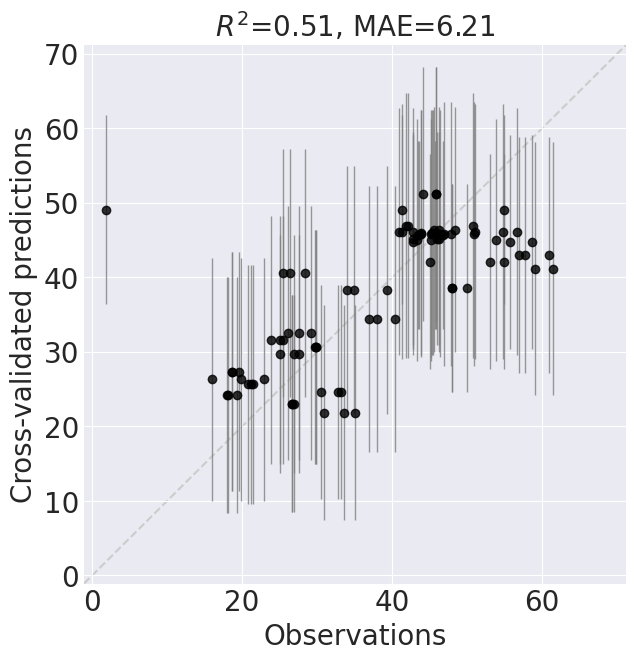

Building models…
Fitting L0 models…
Building TPOT models…


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: XGBRegressor(Binarizer(MinMaxScaler(VarianceThreshold(input_matrix, threshold=0.001)), threshold=0.15000000000000002), learning_rate=0.1, max_depth=1, min_child_weight=11, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.7500000000000001, verbosity=0)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: ExtraTreesRegressor(VarianceThreshold(input_matrix, threshold=0.05), bootstrap=True, max_features=0.9000000000000001, min_samples_leaf=4, min_samples_split=2, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RidgeCV(input_matrix)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: LassoLarsCV(RobustScaler(input_matrix), normalize=False)
Done fitting L0 models in 72.85 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Building ensemble model (4 sampling jobs)…


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, omegas]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 31 seconds.


Done building ensemble model in 43.05 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,2.436537,22.589472,4.155407,23.204120,0.852491
Random Forest Regressor,2.471985,24.315992,4.217348,23.896731,0.848088
Support Vector Regressor,6.271704,40.677593,6.656740,83.646451,0.468258
Kernel Ridge Regressor,3.650151,31.894894,4.849225,36.838580,0.765817
K-NN Regressor,4.668884,32.941171,5.641759,53.627927,0.659087
Gaussian Process Regressor,2.673091,23.746247,4.132773,24.225228,0.846000
Gradient Boosting Regressor,2.415690,22.353386,4.163085,23.166831,0.852728
TPOT Regressor 1,4.244558,35.364872,5.479616,48.042459,0.694593
TPOT Regressor 2,3.982656,33.340874,4.963497,40.497851,0.742555


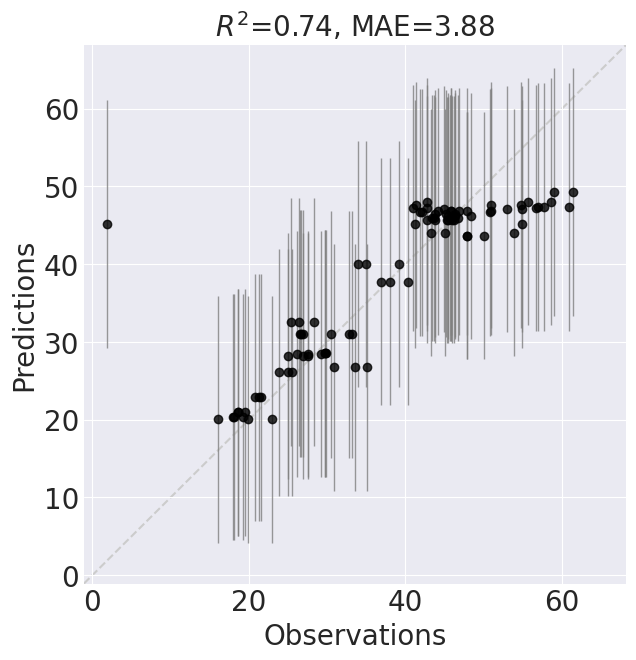

Done building models in 126.89 s


In [324]:
art = train_art(df_stacked, user_params, 'art_dbtl1.cpkl')

In [325]:
art.recommendations = pd.read_csv('../flaviolin data/DBTL2/target_concentrations.csv')[user_params['components']]#.values
recs_df = pd.read_csv('../flaviolin data/DBTL2/target_concentrations.csv')
#recs_df.drop(columns=recs_df.columns[0], axis=1, inplace=True)
mean2, std2 = art.post_pred_stats(recs_df[user_params['components']])


In [ ]:
session = eddu.login(edd_server=edd_server, user=username)

study_slug_2 = 'combinatorial-media-for-flaviolin-repeats-dbtl-2'
df_dbtl2 = eddu.export_study(session, study_slug_2, edd_server=edd_server)


In [ ]:
art.recommendations = pd.read_csv('../flaviolin data/DBTL3/target_concentrations.csv')[user_params['components']]#.values
recs_df = pd.read_csv('../flaviolin data/DBTL3/target_concentrations.csv')
#recs_df.drop(columns=recs_df.columns[0], axis=1, inplace=True)
mean3, std3 = art.post_pred_stats(recs_df[user_params['components']])


In [ ]:
plt.scatter( df_dbtl2['Value']*100, mean)
plt.scatter( df_dbtl3['Value']*100, mean)

plt.plot([10, 70], [10,70])
plt.show()

In [47]:
art.recommendations = pd.read_csv('../flaviolin data/DBTL3/recommendations_x100.csv')[user_params['components']]
art.recommendations

,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM]
0,0.022420,0.671428,2.605823,0.051040,44.923314,0.481388,840.290677,0.000033,0.001189,0.002669,0.011698,0.000954
1,0.022420,0.671428,2.605823,0.051040,44.923314,0.481388,840.290677,0.000028,0.001186,0.002664,0.011697,0.001168
2,0.005656,0.787970,2.645936,0.003302,46.909396,0.465950,599.651769,0.000156,0.001529,0.003978,0.010687,0.001733
3,0.005660,0.787971,2.645936,0.003304,46.909396,0.465950,599.651769,0.000155,0.001542,0.003988,0.011182,0.000788
4,0.005657,0.787971,2.645936,0.003303,46.909396,0.465950,599.651769,0.000154,0.001555,0.003984,0.010687,0.000072
5,0.054624,0.826942,1.823693,0.081543,11.292663,0.407573,944.526064,0.000094,0.004950,0.003796,0.008782,0.001965
6,0.027989,0.981119,1.790250,0.095179,43.702581,0.454384,869.135978,0.000492,0.002063,0.000424,0.005703,0.001469
7,0.040152,0.982509,1.815145,0.091942,43.763601,0.429260,871.789193,0.000488,0.001918,0.000291,0.005786,0.001479
8,0.050413,0.981227,1.790241,0.090259,43.702585,0.454317,869.135978,0.000483,0.001919,0.000169,0.006040,0.001466
9,0.019279,0.638131,2.046703,0.045623,41.052907,0.474170,668.441951,0.000032,0.001272,0.002198,0.012066,0.001177


Starting parallel tempering using 4 chains…
Done with parallel tempering in 611.92 s
Choosing recommendations (19,800 candidates)…


Done choosing recommendations in 0.10 s


,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340
0,0.012617,0.955009,3.953915,0.027791,11.258373,0.398439,305.848578,0.000105,0.000540,0.002800,0.010802,0.001170,60.016553
1,0.012752,0.831059,4.608710,0.048600,11.417979,0.443694,260.359586,0.000032,0.001088,0.002126,0.004306,0.000139,59.954489
2,0.012754,0.831059,4.608710,0.048600,11.417979,0.443694,260.359586,0.000031,0.001064,0.002681,0.004312,0.000130,59.953442
3,0.012857,0.822034,4.815663,0.049373,11.120574,0.466887,273.492435,0.000032,0.000924,0.002262,0.003519,0.000102,59.942812
4,0.012857,0.822034,4.815663,0.049373,11.120574,0.466887,273.492435,0.000032,0.000924,0.002262,0.003519,0.000078,59.942525
5,0.009753,0.962405,3.712993,0.020578,11.506382,0.431664,329.368535,0.000095,0.000863,0.003095,0.011388,0.001335,59.795304
6,0.011681,0.659752,4.567232,0.032779,12.042927,0.491263,308.052199,0.000065,0.000840,0.001209,0.010634,0.000216,59.722817
7,0.009478,0.961192,3.959196,0.023499,11.240618,0.398045,319.357610,0.000088,0.000490,0.002763,0.010324,0.001237,59.688902
8,0.009235,0.597575,4.683321,0.036602,11.306248,0.531213,267.205132,0.000035,0.001045,0.003112,0.004723,0.000126,59.685851
9,0.011445,0.961602,3.803220,0.043712,12.048329,0.436444,362.369417,0.000088,0.000920,0.003274,0.002566,0.001721,59.648534


Sampling posterior predictive distributions…


Sampling: [y]


Done sampling in 2.17 s


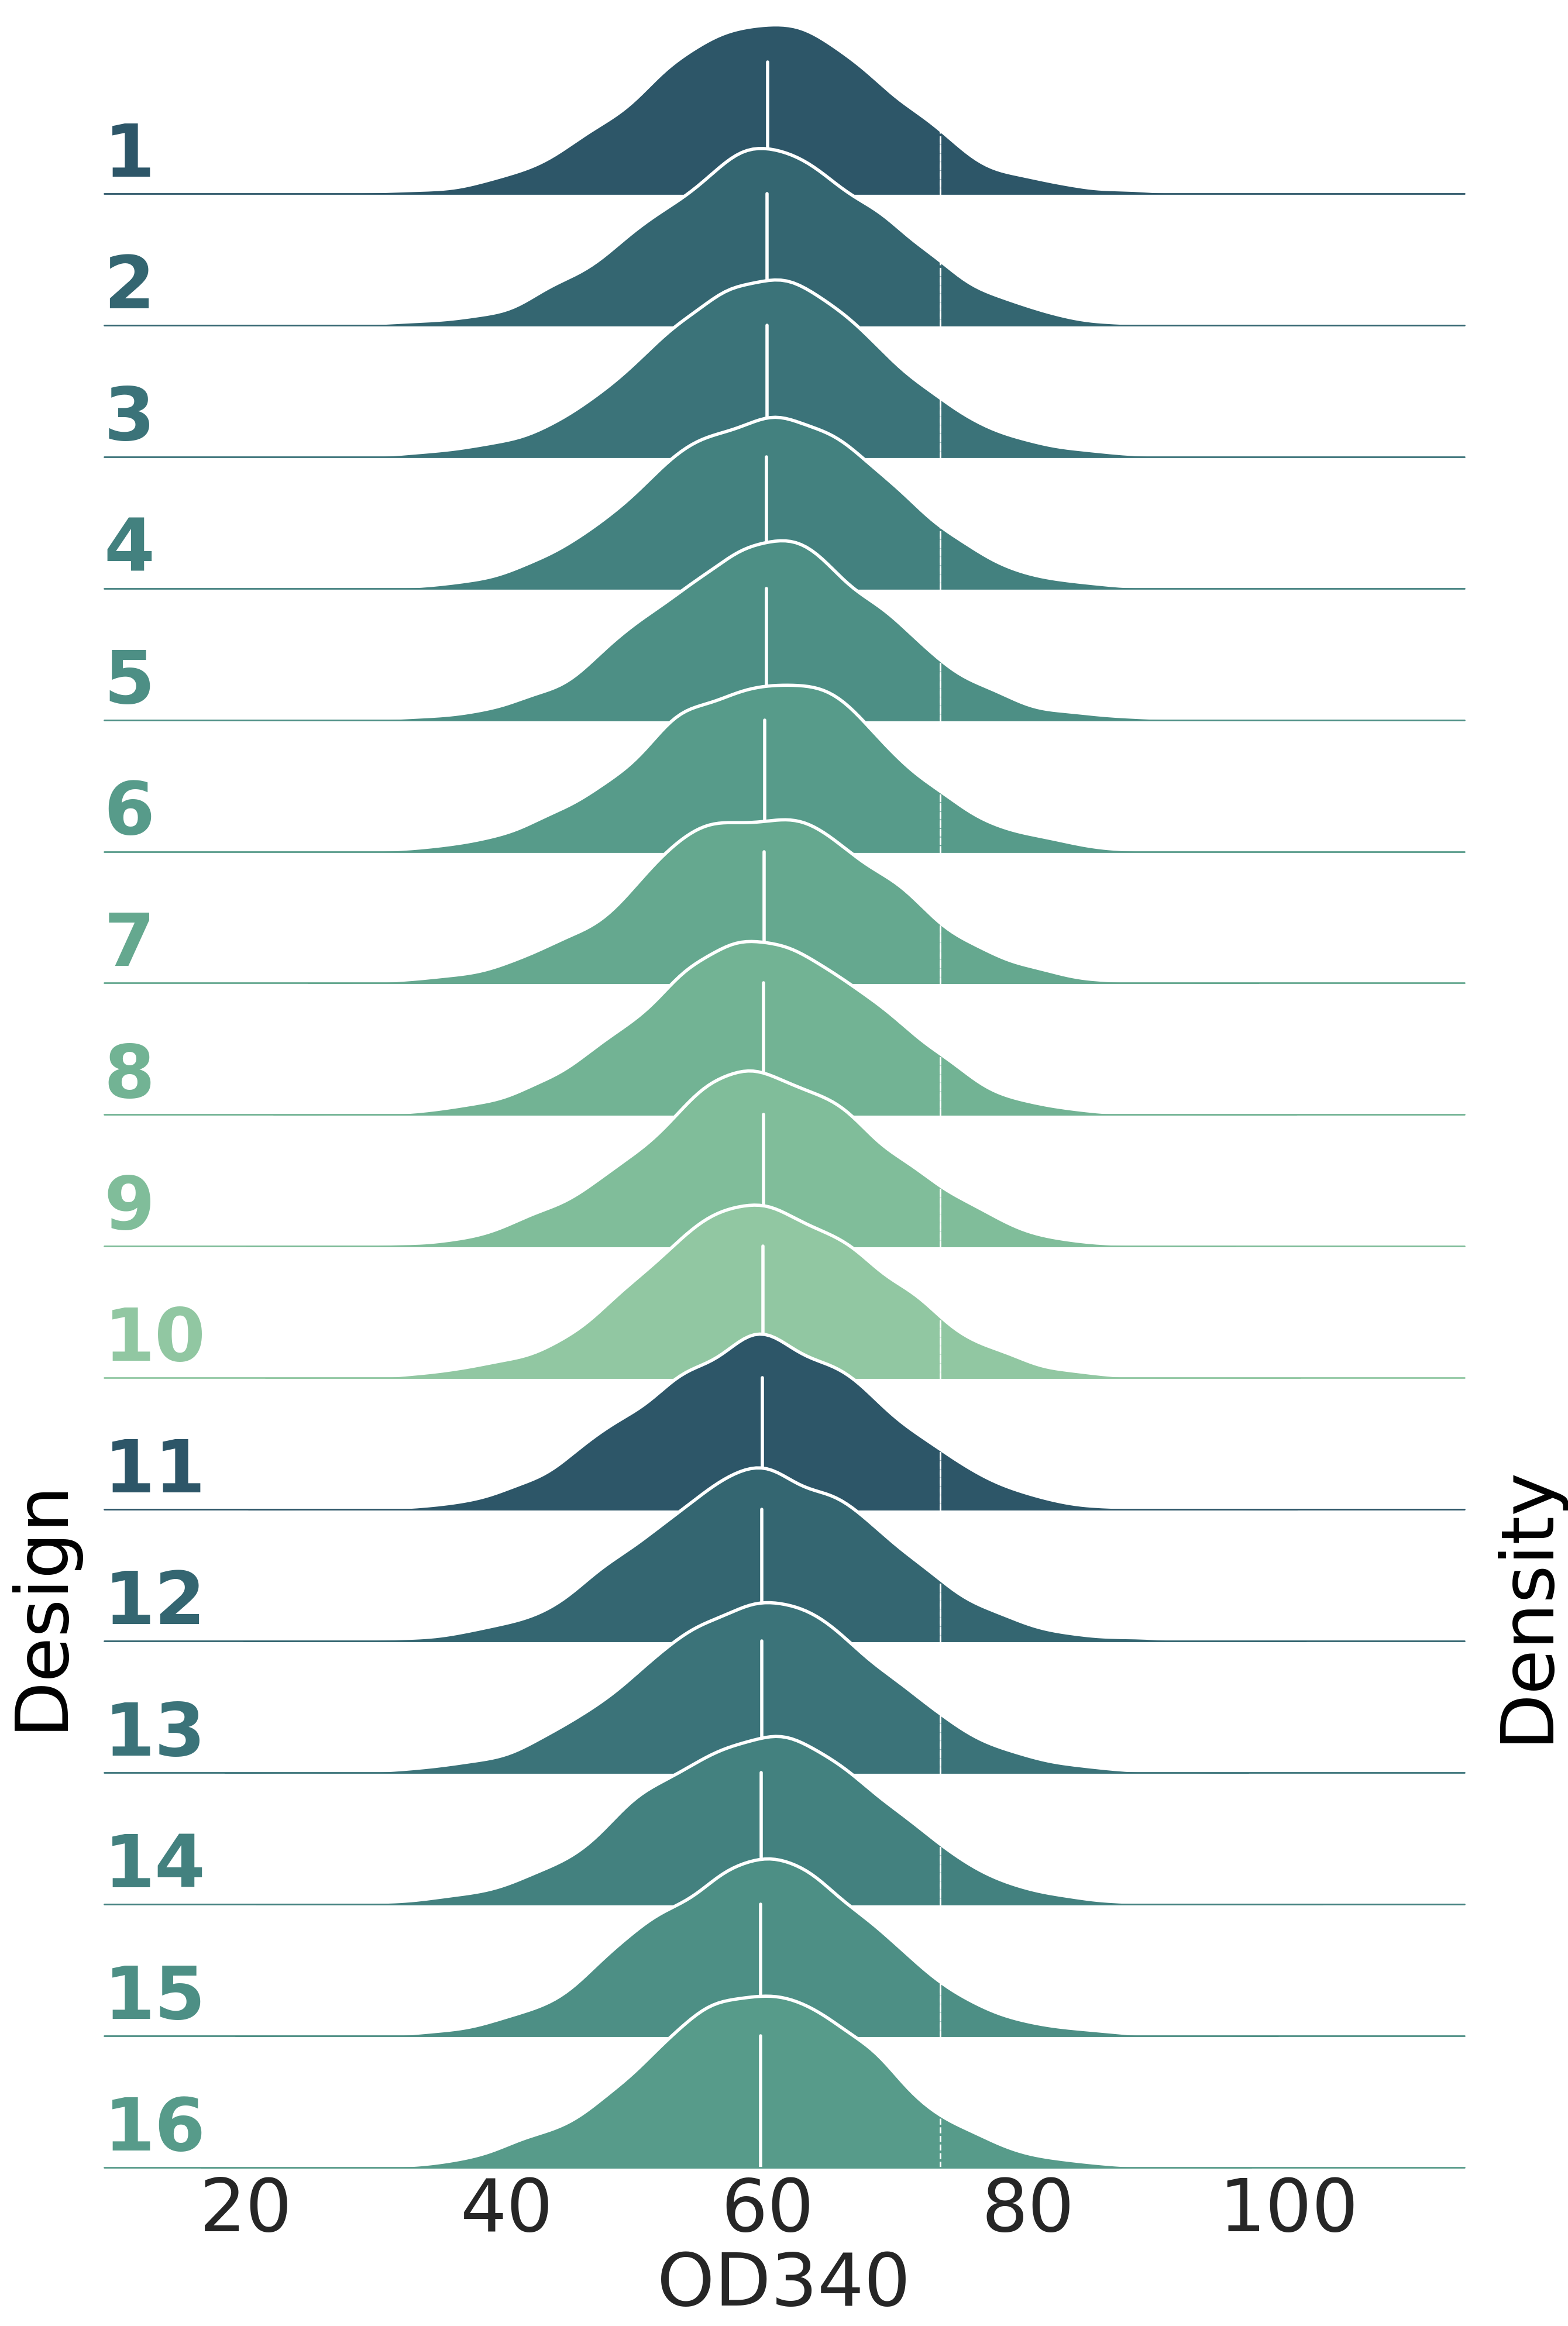

Sampling: [y]


Computing success probabilities…
Sampling posterior predictive distributions…
Done sampling in 2.50 s
Done computing success probabilities in 2.50 s


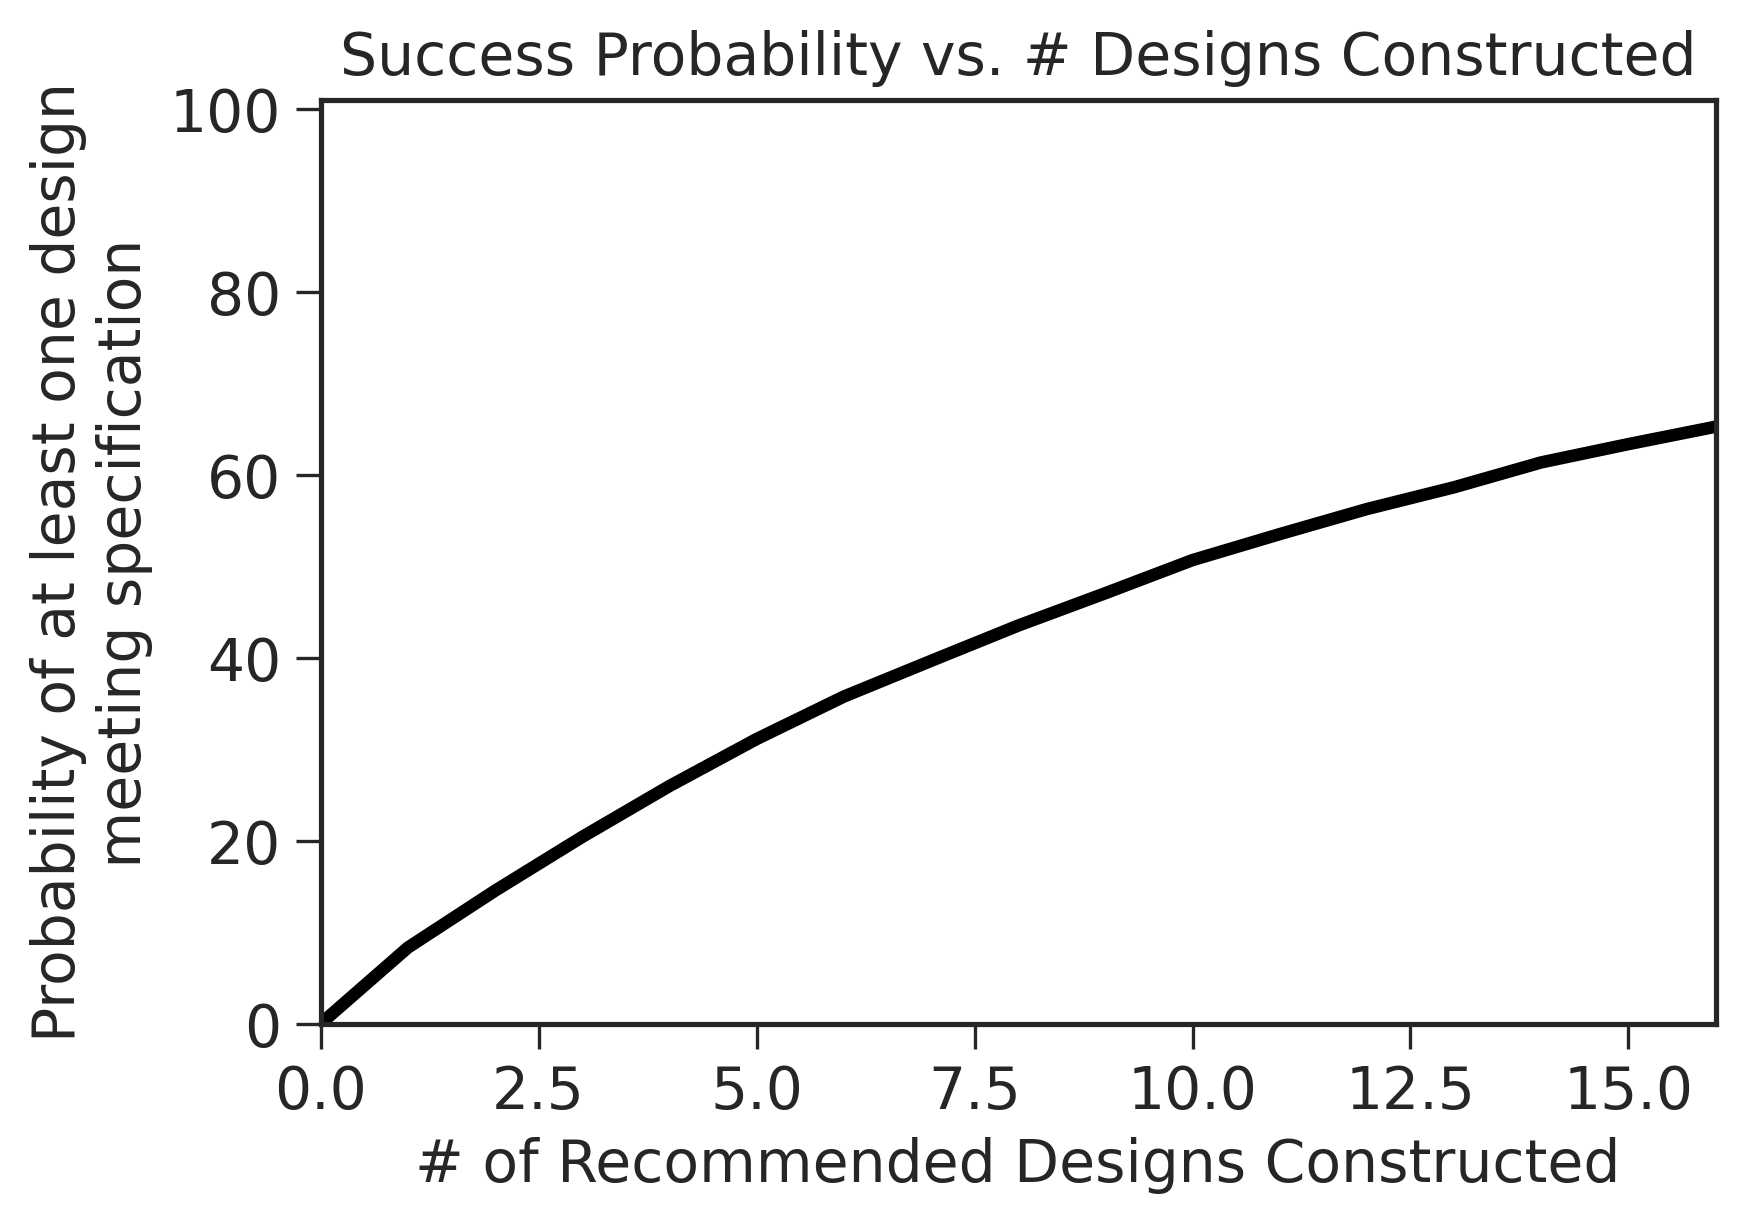

In [41]:
art.recommend()

In [42]:
art.alpha

0.0

In [43]:
user_params['n_instances_exploit'] = 8

In [44]:
df_recs_exploit = art.recommendations.iloc[:user_params['n_instances_exploit'],:]

In [45]:
df_recs_exploit

,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340
0,0.012617,0.955009,3.953915,0.027791,11.258373,0.398439,305.848578,0.000105,0.000540,0.002800,0.010802,0.001170,60.016553
1,0.012752,0.831059,4.608710,0.048600,11.417979,0.443694,260.359586,0.000032,0.001088,0.002126,0.004306,0.000139,59.954489
2,0.012754,0.831059,4.608710,0.048600,11.417979,0.443694,260.359586,0.000031,0.001064,0.002681,0.004312,0.000130,59.953442
3,0.012857,0.822034,4.815663,0.049373,11.120574,0.466887,273.492435,0.000032,0.000924,0.002262,0.003519,0.000102,59.942812
4,0.012857,0.822034,4.815663,0.049373,11.120574,0.466887,273.492435,0.000032,0.000924,0.002262,0.003519,0.000078,59.942525
5,0.009753,0.962405,3.712993,0.020578,11.506382,0.431664,329.368535,0.000095,0.000863,0.003095,0.011388,0.001335,59.795304
6,0.011681,0.659752,4.567232,0.032779,12.042927,0.491263,308.052199,0.000065,0.000840,0.001209,0.010634,0.000216,59.722817
7,0.009478,0.961192,3.959196,0.023499,11.240618,0.398045,319.357610,0.000088,0.000490,0.002763,0.010324,0.001237,59.688902


In [46]:
art.recommendation_stats

{'prediction_mean': [[60.01655312905899],
  [59.954489044263454],
  [59.95344236276014],
  [59.94281199546767],
  [59.94252501893398],
  [59.79530372340441],
  [59.72281669360621],
  [59.68890195814727],
  [59.68585133047313],
  [59.6485335736636],
  [59.59137225312508],
  [59.57226089763775],
  [59.547679916864666],
  [59.53742495517787],
  [59.493164900272646],
  [59.4774364942881]],
 'prediction_std': [[9.256333026225178],
  [9.219365736594096],
  [9.219107964324603],
  [9.221335787629847],
  [9.221305910313804],
  [9.252552487241609],
  [9.20981313423656],
  [9.224797293198094],
  [9.190800270697167],
  [9.284885632175168],
  [9.2298562803694],
  [9.276499529137288],
  [9.274831099458629],
  [9.279386611685503],
  [9.259086111149063],
  [9.22217332597595]]}

In [47]:
recs_exploit_stats = art.recommendation_stats.copy()
for key in recs_exploit_stats.keys():
    recs_exploit_stats[key] = recs_exploit_stats[key][:user_params['n_instances_exploit']]

In [48]:
recs_exploit_stats

{'prediction_mean': [[60.01655312905899],
  [59.954489044263454],
  [59.95344236276014],
  [59.94281199546767],
  [59.94252501893398],
  [59.79530372340441],
  [59.72281669360621],
  [59.68890195814727]],
 'prediction_std': [[9.256333026225178],
  [9.219365736594096],
  [9.219107964324603],
  [9.221335787629847],
  [9.221305910313804],
  [9.252552487241609],
  [9.20981313423656],
  [9.224797293198094]]}

In [49]:
df_recs_exploit['OD340'] = np.array(recs_exploit_stats['prediction_mean']).flatten()
df_recs_exploit['OD340_std'] = np.array(recs_exploit_stats['prediction_std']).flatten()
df_recs_exploit['Label'] = 'exploit'

/tmp/ipykernel_41757/2099693226.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recs_exploit['OD340'] = np.array(recs_exploit_stats['prediction_mean']).flatten()
/tmp/ipykernel_41757/2099693226.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recs_exploit['OD340_std'] = np.array(recs_exploit_stats['prediction_std']).flatten()
/tmp/ipykernel_41757/2099693226.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [50]:
df_recs_exploit

,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340,OD340_std,Label
0,0.012617,0.955009,3.953915,0.027791,11.258373,0.398439,305.848578,0.000105,0.000540,0.002800,0.010802,0.001170,60.016553,9.256333,exploit
1,0.012752,0.831059,4.608710,0.048600,11.417979,0.443694,260.359586,0.000032,0.001088,0.002126,0.004306,0.000139,59.954489,9.219366,exploit
2,0.012754,0.831059,4.608710,0.048600,11.417979,0.443694,260.359586,0.000031,0.001064,0.002681,0.004312,0.000130,59.953442,9.219108,exploit
3,0.012857,0.822034,4.815663,0.049373,11.120574,0.466887,273.492435,0.000032,0.000924,0.002262,0.003519,0.000102,59.942812,9.221336,exploit
4,0.012857,0.822034,4.815663,0.049373,11.120574,0.466887,273.492435,0.000032,0.000924,0.002262,0.003519,0.000078,59.942525,9.221306,exploit
5,0.009753,0.962405,3.712993,0.020578,11.506382,0.431664,329.368535,0.000095,0.000863,0.003095,0.011388,0.001335,59.795304,9.252552,exploit
6,0.011681,0.659752,4.567232,0.032779,12.042927,0.491263,308.052199,0.000065,0.000840,0.001209,0.010634,0.000216,59.722817,9.209813,exploit
7,0.009478,0.961192,3.959196,0.023499,11.240618,0.398045,319.357610,0.000088,0.000490,0.002763,0.010324,0.001237,59.688902,9.224797,exploit


In [174]:
art.bounds

,Min,Max
Variable,,
H3BO3[mM],0.000400,0.0800
K2SO4[mM],0.010000,1.0000
K2HPO4[mM],0.264000,13.2000
FeSO4[mM],0.001000,0.1000
NH4Cl[mM],6.400000,47.6000
MgCl2[mM],0.026000,2.6000
NaCl[mM],5.000000,1000.0000
(NH4)6Mo7O24[mM],0.000003,0.0006
CoCl2[mM],0.000030,0.0060


In [288]:
%%time
from scipy.optimize import differential_evolution, Bounds


foo = art.post_pred_stats(art.X[0,:])
(1-art.alpha)*foo[0] +  art.alpha*foo[1]

def obj_func(x, art, draws):
    #print(x.shape)
    foo = art.post_pred_stats(x)
    #file1.write(str(x.flatten()[1:-1]))
    G = np.squeeze((1-art.alpha)*foo[0] +  art.alpha*foo[1])
    draws.append(np.append(x,G))
    
    return -G

#file1 = open("myfile.txt", "a")  # append mode
draws = []
f = lambda x: obj_func(x,art, draws)
# bounds = art.bounds.values
# bounds = Bounds(art.bounds.values)
bounds = Bounds(art.bounds.values[:,0], art.bounds.values[:,1])
result = differential_evolution(f, bounds, maxiter = 100, popsize= 500, vectorized = False)
# file1.close()


CPU times: user 24min 49s, sys: 7.79 s, total: 24min 56s
Wall time: 24min 56s


In [289]:
print(str(result.x.flatten())[1:-1])
print(result.fun)
# df_diff_evol = 

1.72777876e-02 8.27457826e-01 2.62801432e+00 3.82049800e-02
 1.15575720e+01 4.37580561e-01 4.37117372e+02 2.27961685e-05
 4.67885340e-05 2.50198321e-03 9.28555700e-03 1.51302656e-03
-63.24992135704339


In [290]:
draws = np.array(draws)

In [291]:
foo = draws[:50, :-1]
bar = art.post_pred_stats(foo)
means = bar[0]
std = bar[1]
buz = 0.5*bar[0] + 0.5*bar[1]
#buz = np.squeeze(buz)

In [292]:
buz.shape
foo.shape
#np.append(foo,buz, axis=1)

(50, 12)

In [293]:
len(buz)

50

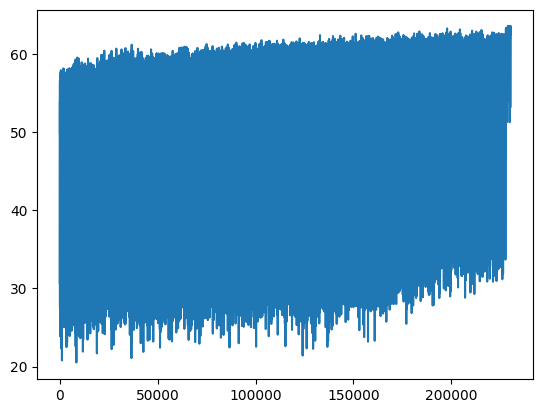

In [294]:
plt.plot(range(draws.shape[0]), draws[:,-1])
plt.show()

In [307]:
np.hstack((draws, np.reshape(draws[:,-1], [-1,1]))).shape

(230509, 14)

In [318]:
from art.core.recommender import Recommender
draws_padded = np.hstack((draws, np.reshape(draws[:,-1], [-1,1])))

art.rel_rec_distance = .5
recommender = Recommender(
            art.loader,
            art.create_bounds(),
            art._args,
            publish_recs=False,
            # ### Pass-through RE params  #######
            # self.input_vars,
            # self.num_recommendations,
            # self.output_dir,
            # self.rel_rec_distance,
            # self.response_vars,
            # self.testing,
            # self.verbose,
            # self.warning_callback,
        )

recommendations = recommender.select(draws_padded)


Choosing recommendations (230,509 candidates)…


Done choosing recommendations in 2.79 s


In [319]:
mean, std = art.post_pred_stats(recommendations) 

In [320]:
recommendations['OD340_pred'] = mean
recommendations['OD340_std'] = std
recommendations

,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340_pred,OD340_std
0,0.016462,0.827511,2.628113,0.041190,11.557574,0.437507,437.117372,0.000047,0.000049,0.002500,0.009280,0.001512,63.499187,8.310927
1,0.017272,0.827487,2.628069,0.038228,11.557573,0.437540,437.117372,0.000023,0.000049,0.002501,0.009282,0.001513,63.252705,8.296932
2,0.015944,0.841262,2.713247,0.037559,11.694556,0.405956,430.860887,0.000004,0.000046,0.000256,0.014284,0.000955,63.129866,8.299673
3,0.017440,0.933066,2.686798,0.052831,11.203440,0.440475,458.096312,0.000033,0.000043,0.000811,0.010471,0.001514,62.961245,8.273741
4,0.011643,0.922674,2.212028,0.037536,10.454316,0.666945,443.541247,0.000006,0.000046,0.003481,0.002895,0.000482,62.839989,8.304048
5,0.015429,0.827541,2.628170,0.044975,11.557574,0.437465,437.117372,0.000086,0.000047,0.002499,0.009277,0.001512,62.808057,8.269699
6,0.019016,0.857601,2.593787,0.040219,10.263895,0.413249,441.453630,0.000032,0.000039,0.004663,0.012372,0.001528,62.778832,8.300836
7,0.021282,0.777939,2.393411,0.043468,10.102100,0.457413,422.038374,0.000054,0.000048,0.002175,0.009664,0.000581,62.757052,8.301244
8,0.012861,0.611726,2.534114,0.040691,10.342193,0.517606,416.963629,0.000010,0.000036,0.003281,0.006060,0.001415,62.660954,8.288989
9,0.027008,0.888317,2.250012,0.043477,11.614804,0.483705,445.630997,0.000046,0.000031,0.005770,0.005928,0.001520,62.659741,8.308338


In [321]:
art.alpha = 0.8

Starting parallel tempering using 4 chains…
Done with parallel tempering in 585.22 s
Choosing recommendations (19,800 candidates)…


Done choosing recommendations in 0.06 s


,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340
0,0.001342,0.720393,11.575897,0.004724,46.933478,0.174994,199.103721,0.000046,0.000350,0.004755,0.007046,0.000100,54.061754
1,0.001661,0.690209,11.359491,0.006795,46.382821,0.180445,199.679830,0.000039,0.000545,0.004858,0.007409,0.000076,54.577202
2,0.001601,0.684843,11.503949,0.006216,46.423272,0.261439,192.074525,0.000042,0.000536,0.004883,0.006744,0.000072,54.042473
3,0.007853,0.320841,11.492618,0.006030,44.625227,0.187981,197.792335,0.000036,0.000392,0.004590,0.007262,0.001147,53.909132
4,0.008116,0.873950,11.491927,0.005057,44.625497,0.175128,197.792329,0.000025,0.000386,0.004784,0.007041,0.001174,53.845113
5,0.017382,0.378489,12.891118,0.021220,47.008025,0.433047,273.315028,0.000172,0.002701,0.002684,0.012499,0.001246,54.265010
6,0.001667,0.721483,11.492117,0.004769,44.625421,0.178664,197.792330,0.000033,0.000392,0.004720,0.007041,0.001164,53.866037
7,0.001672,0.721498,11.490735,0.004770,44.622443,0.178732,199.098361,0.000046,0.000394,0.004741,0.007040,0.000105,53.862384
8,0.017003,0.170142,12.397916,0.023842,46.281597,0.508790,354.938567,0.000096,0.000730,0.005263,0.002250,0.001394,54.546947
9,0.017003,0.170142,12.397916,0.023842,46.281597,0.508790,354.938567,0.000068,0.000792,0.005428,0.002249,0.001718,54.543686


Sampling posterior predictive distributions…


Sampling: [y]


Done sampling in 2.12 s


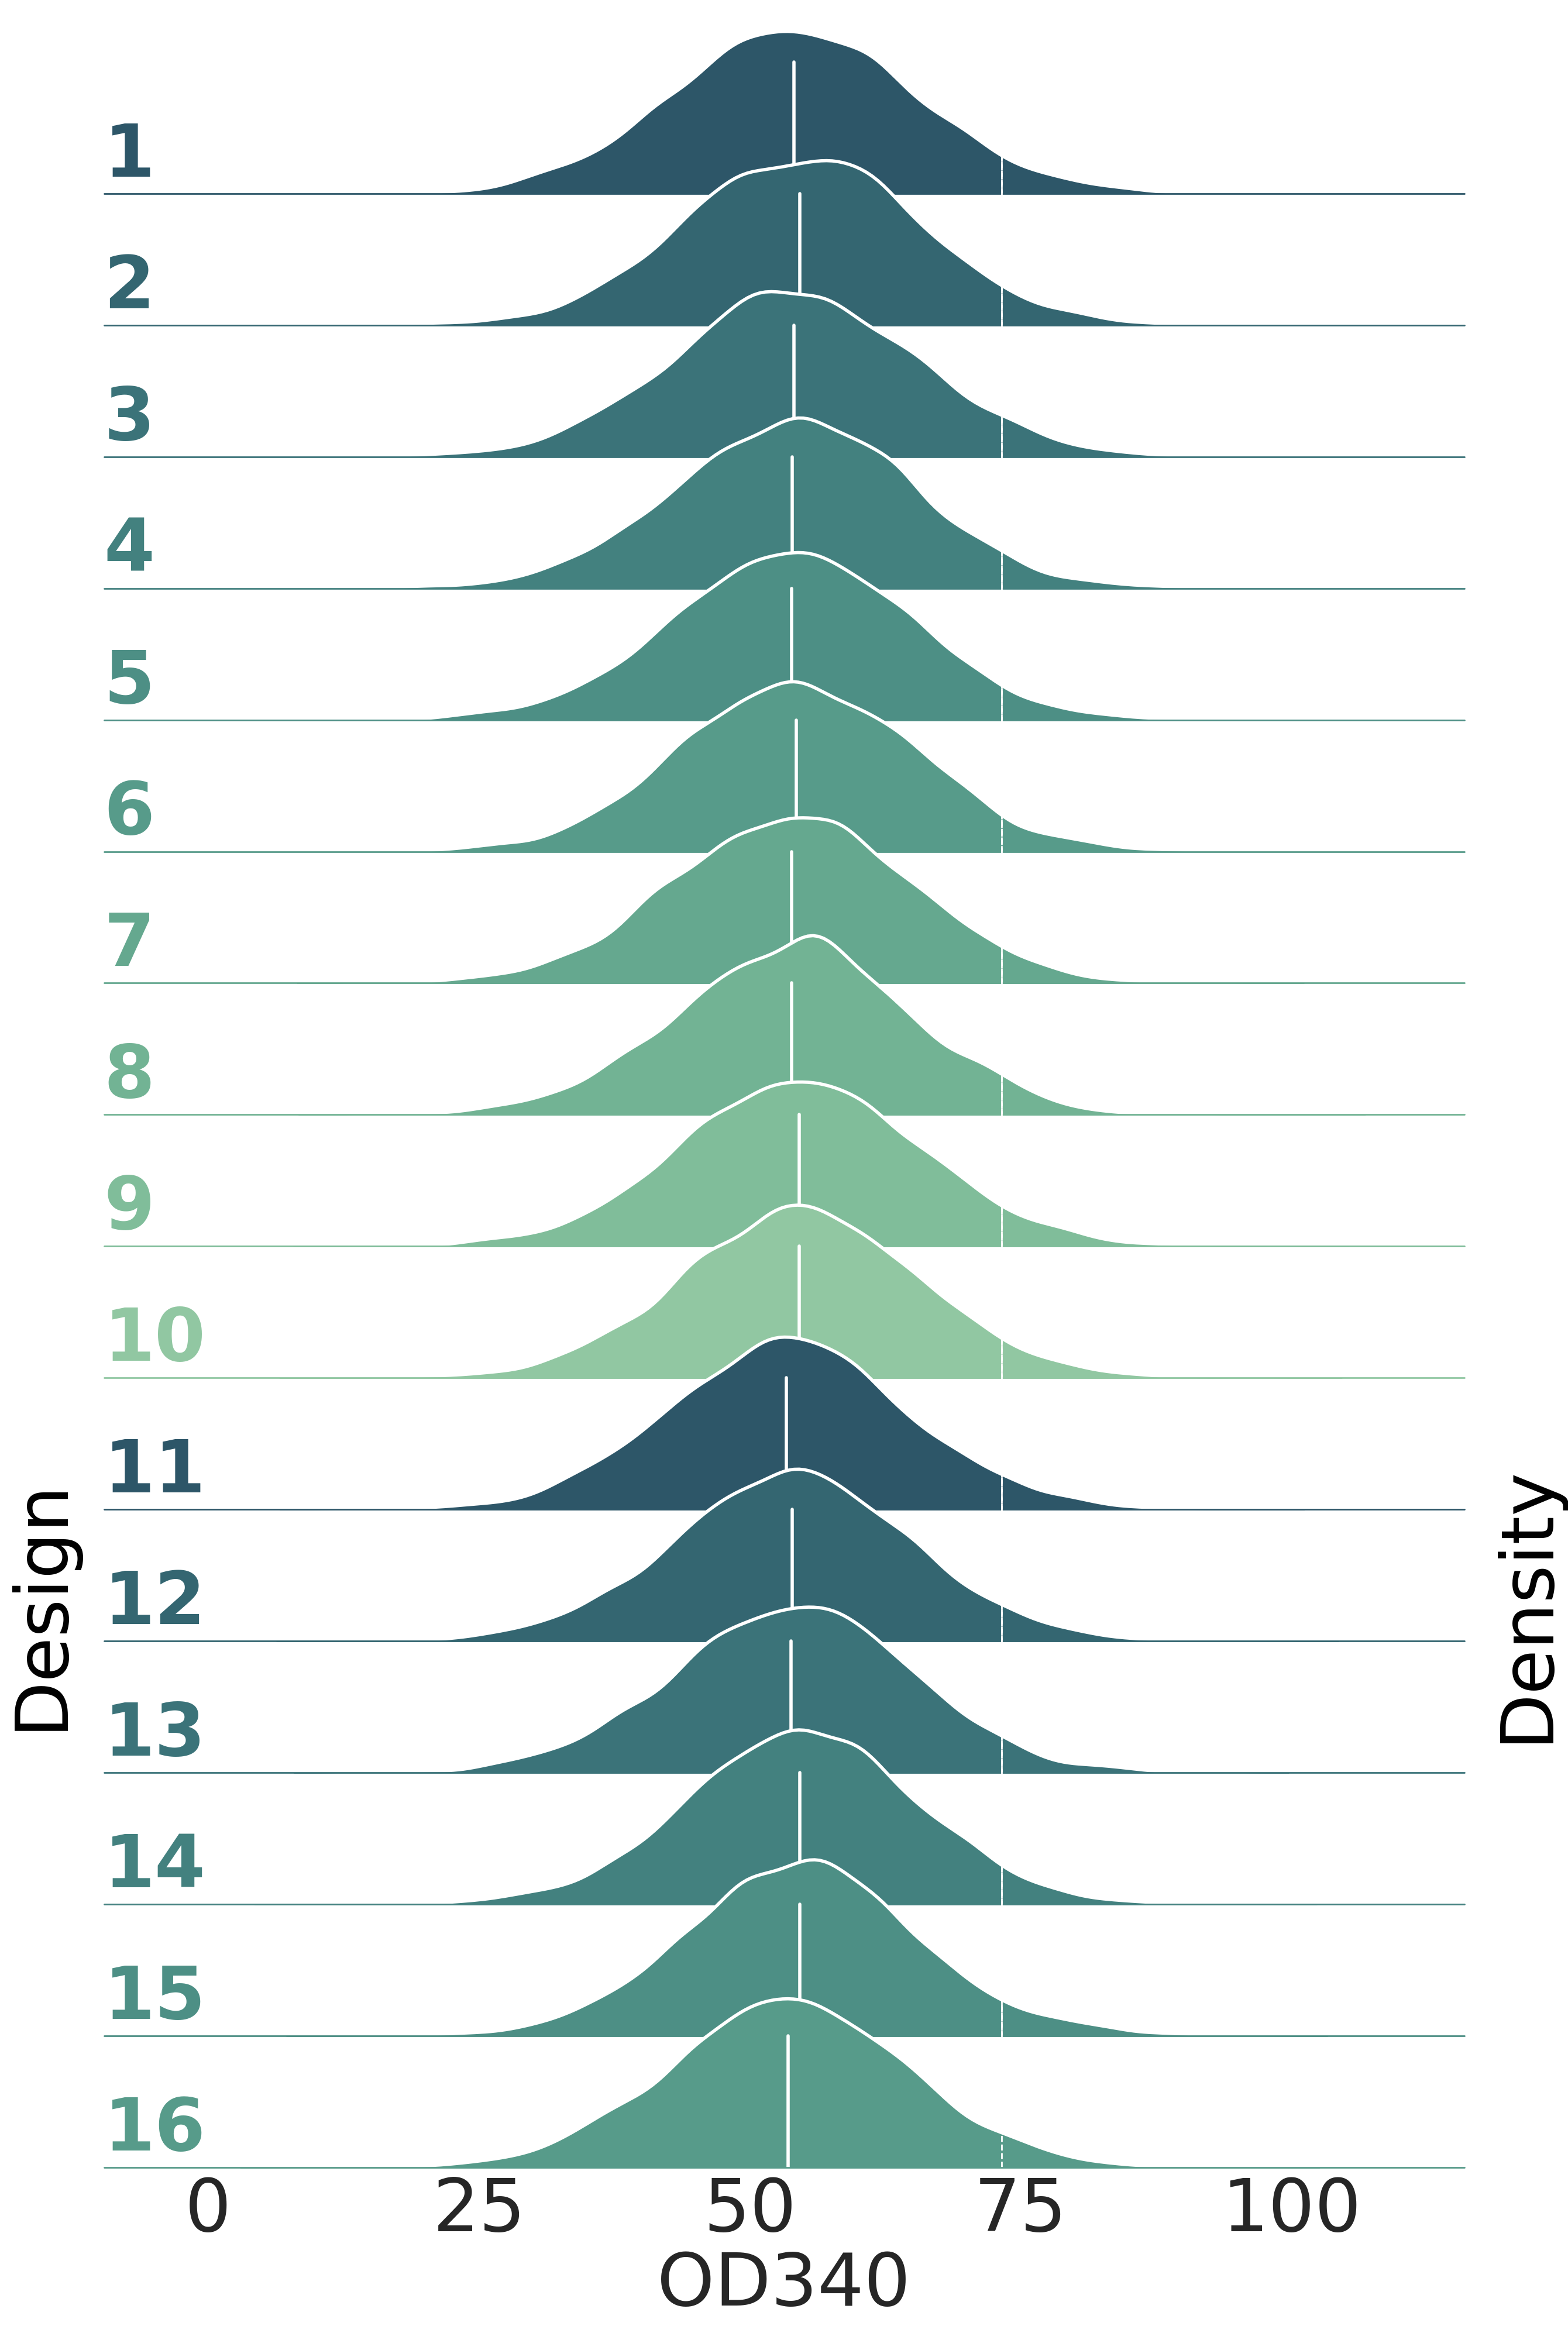

Sampling: [y]


Computing success probabilities…
Sampling posterior predictive distributions…
Done sampling in 2.48 s
Done computing success probabilities in 2.49 s


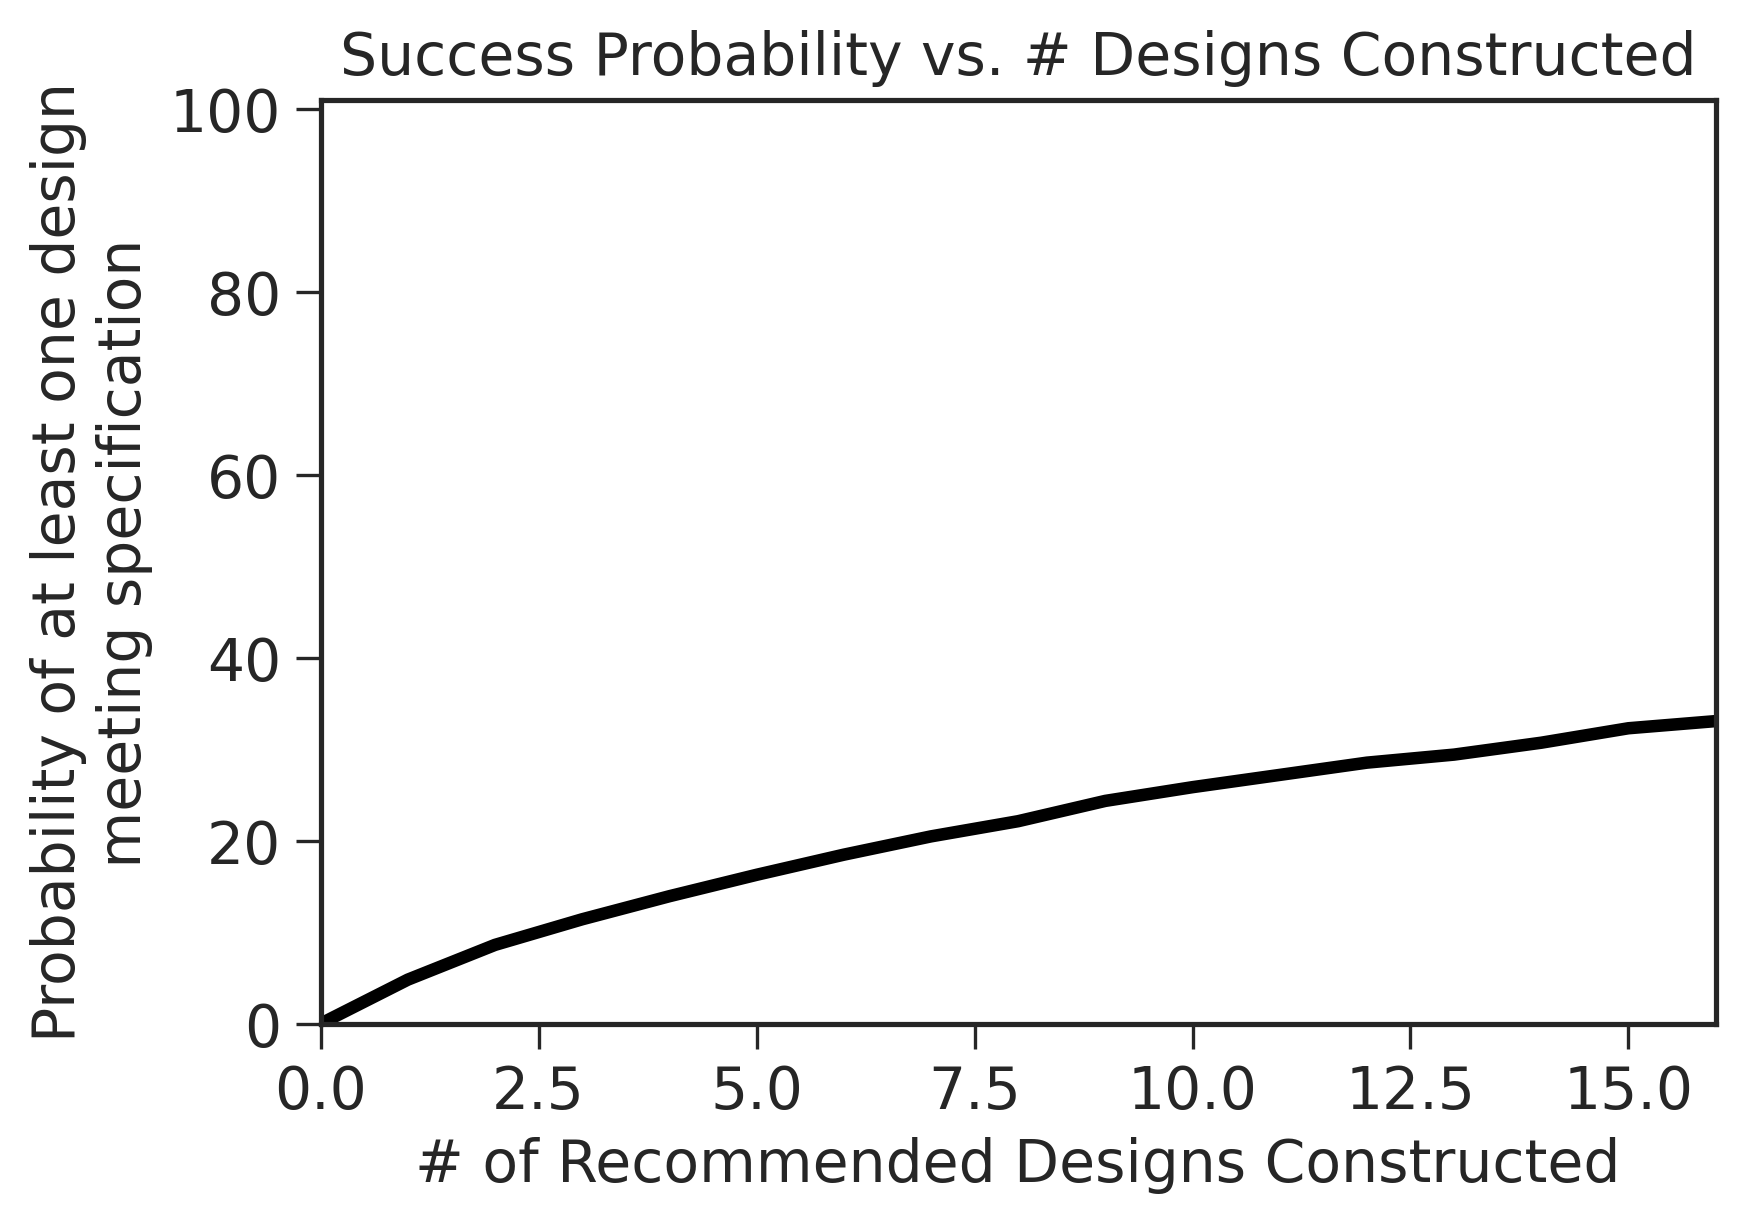

In [52]:
art.recommend()

In [53]:
user_params['n_instances_explore'] = 7

In [54]:
df_recs_explore = art.recommendations.iloc[:user_params['n_instances_explore'],:]

In [55]:
df_recs_explore

,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340
0,0.001342,0.720393,11.575897,0.004724,46.933478,0.174994,199.103721,0.000046,0.000350,0.004755,0.007046,0.000100,54.061754
1,0.001661,0.690209,11.359491,0.006795,46.382821,0.180445,199.679830,0.000039,0.000545,0.004858,0.007409,0.000076,54.577202
2,0.001601,0.684843,11.503949,0.006216,46.423272,0.261439,192.074525,0.000042,0.000536,0.004883,0.006744,0.000072,54.042473
3,0.007853,0.320841,11.492618,0.006030,44.625227,0.187981,197.792335,0.000036,0.000392,0.004590,0.007262,0.001147,53.909132
4,0.008116,0.873950,11.491927,0.005057,44.625497,0.175128,197.792329,0.000025,0.000386,0.004784,0.007041,0.001174,53.845113
5,0.017382,0.378489,12.891118,0.021220,47.008025,0.433047,273.315028,0.000172,0.002701,0.002684,0.012499,0.001246,54.265010
6,0.001667,0.721483,11.492117,0.004769,44.625421,0.178664,197.792330,0.000033,0.000392,0.004720,0.007041,0.001164,53.866037


In [56]:
art.recommendation_stats

{'prediction_mean': [[54.06175420748171],
  [54.57720201303903],
  [54.042473351237035],
  [53.909132485917155],
  [53.84511255386633],
  [54.265009707133935],
  [53.86603693587193],
  [53.86238359798058],
  [54.54694724408634],
  [54.54368604556949],
  [53.35406754415828],
  [53.89204346616695],
  [53.78740876852116],
  [54.62797685139585],
  [54.612672533642424],
  [53.50458386667448]],
 'prediction_std': [[11.131440332737217],
  [11.052985009653817],
  [11.095410111795948],
  [11.06488315962113],
  [11.055749907220944],
  [10.988742826728915],
  [11.04518153585674],
  [11.043711557050695],
  [10.940351820526828],
  [10.939079351007697],
  [11.085621951359895],
  [10.974928726555099],
  [10.96807361049477],
  [10.820717192457986],
  [10.815308149198833],
  [10.963625962388083]]}

In [57]:
recs_explore_stats = art.recommendation_stats.copy()
for key in recs_explore_stats.keys():
    recs_explore_stats[key] = recs_explore_stats[key][:user_params['n_instances_explore']]

In [58]:
recs_explore_stats

{'prediction_mean': [[54.06175420748171],
  [54.57720201303903],
  [54.042473351237035],
  [53.909132485917155],
  [53.84511255386633],
  [54.265009707133935],
  [53.86603693587193]],
 'prediction_std': [[11.131440332737217],
  [11.052985009653817],
  [11.095410111795948],
  [11.06488315962113],
  [11.055749907220944],
  [10.988742826728915],
  [11.04518153585674]]}

In [59]:
df_recs_explore['OD340'] = np.array(recs_explore_stats['prediction_mean']).flatten()
df_recs_explore['OD340_std'] = np.array(recs_explore_stats['prediction_std']).flatten()
df_recs_explore['Label'] = 'explore'


/tmp/ipykernel_41757/2388116331.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recs_explore['OD340'] = np.array(recs_explore_stats['prediction_mean']).flatten()
/tmp/ipykernel_41757/2388116331.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recs_explore['OD340_std'] = np.array(recs_explore_stats['prediction_std']).flatten()
/tmp/ipykernel_41757/2388116331.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [60]:
df_recs_explore

,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340,OD340_std,Label
0,0.001342,0.720393,11.575897,0.004724,46.933478,0.174994,199.103721,0.000046,0.000350,0.004755,0.007046,0.000100,54.061754,11.131440,explore
1,0.001661,0.690209,11.359491,0.006795,46.382821,0.180445,199.679830,0.000039,0.000545,0.004858,0.007409,0.000076,54.577202,11.052985,explore
2,0.001601,0.684843,11.503949,0.006216,46.423272,0.261439,192.074525,0.000042,0.000536,0.004883,0.006744,0.000072,54.042473,11.095410,explore
3,0.007853,0.320841,11.492618,0.006030,44.625227,0.187981,197.792335,0.000036,0.000392,0.004590,0.007262,0.001147,53.909132,11.064883,explore
4,0.008116,0.873950,11.491927,0.005057,44.625497,0.175128,197.792329,0.000025,0.000386,0.004784,0.007041,0.001174,53.845113,11.055750,explore
5,0.017382,0.378489,12.891118,0.021220,47.008025,0.433047,273.315028,0.000172,0.002701,0.002684,0.012499,0.001246,54.265010,10.988743,explore
6,0.001667,0.721483,11.492117,0.004769,44.625421,0.178664,197.792330,0.000033,0.000392,0.004720,0.007041,0.001164,53.866037,11.045182,explore


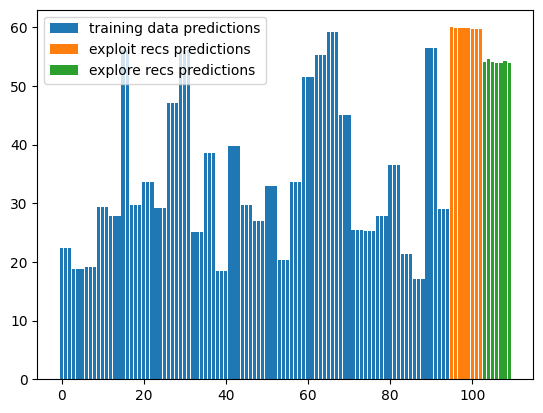

In [61]:
fig, ax = plt.subplots()
ax.bar(range(art.X.shape[0]),art.predict(art.X).flatten(), label = 'training data predictions')
ax.bar(range(art.X.shape[0], art.X.shape[0]+user_params['n_instances_exploit']), np.array(recs_exploit_stats['prediction_mean']).flatten(), label = 'exploit recs predictions')
ax.bar(range(art.X.shape[0]+user_params['n_instances_exploit'],art.X.shape[0]+user_params['n_instances_exploit']+user_params['n_instances_explore'])\
        , np.array(recs_explore_stats['prediction_mean']).flatten(), label = 'explore recs predictions')
ax.legend()
plt.show()
fig.savefig(user_params['output_dir']+'/rec_bar_graph_x100_outlier_removed.png')

In [62]:
df_target = pd.concat([df_recs_explore, df_recs_exploit]).reset_index()
df_target.rename(columns={'OD340': 'OD340_pred'}, inplace=True)

In [63]:
df_target

,index,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340_pred,OD340_std,Label
0,0,0.001342,0.720393,11.575897,0.004724,46.933478,0.174994,199.103721,0.000046,0.000350,0.004755,0.007046,0.000100,54.061754,11.131440,explore
1,1,0.001661,0.690209,11.359491,0.006795,46.382821,0.180445,199.679830,0.000039,0.000545,0.004858,0.007409,0.000076,54.577202,11.052985,explore
2,2,0.001601,0.684843,11.503949,0.006216,46.423272,0.261439,192.074525,0.000042,0.000536,0.004883,0.006744,0.000072,54.042473,11.095410,explore
3,3,0.007853,0.320841,11.492618,0.006030,44.625227,0.187981,197.792335,0.000036,0.000392,0.004590,0.007262,0.001147,53.909132,11.064883,explore
4,4,0.008116,0.873950,11.491927,0.005057,44.625497,0.175128,197.792329,0.000025,0.000386,0.004784,0.007041,0.001174,53.845113,11.055750,explore
5,5,0.017382,0.378489,12.891118,0.021220,47.008025,0.433047,273.315028,0.000172,0.002701,0.002684,0.012499,0.001246,54.265010,10.988743,explore
6,6,0.001667,0.721483,11.492117,0.004769,44.625421,0.178664,197.792330,0.000033,0.000392,0.004720,0.007041,0.001164,53.866037,11.045182,explore
7,0,0.012617,0.955009,3.953915,0.027791,11.258373,0.398439,305.848578,0.000105,0.000540,0.002800,0.010802,0.001170,60.016553,9.256333,exploit
8,1,0.012752,0.831059,4.608710,0.048600,11.417979,0.443694,260.359586,0.000032,0.001088,0.002126,0.004306,0.000139,59.954489,9.219366,exploit
9,2,0.012754,0.831059,4.608710,0.048600,11.417979,0.443694,260.359586,0.000031,0.001064,0.002681,0.004312,0.000130,59.953442,9.219108,exploit


In [64]:
user_params['standard_media_file']

'../flaviolin data/standard_recipe_concentrations.csv'

In [65]:
df_stand = pd.read_csv(user_params['standard_media_file']).set_index("Component")
df_stand = df_stand.rename(columns = {"Concentration":'Concentration[mM]'} )
df_stand

,Concentration[mM],Solubility
Component,,
MOPS[mM],40.00000,1700.00
Tricine[mM],4.00000,500.08
H3BO3[mM],0.00400,700.00
Glucose[mM],20.00000,5045.63
K2SO4[mM],0.29000,636.98
K2HPO4[mM],1.32000,8564.84
FeSO4[mM],0.01000,1645.73
NH4Cl[mM],9.52000,6543.28
MgCl2[mM],0.52000,569.27


In [66]:
ub = 1.1
lb = 0.9
df_control = pd.DataFrame(columns=user_params['components'])

for component in user_params['components']:
    stand_conc = df_stand.loc[component]['Concentration[mM]']
    df_control.at['Control', component] = stand_conc*np.random.uniform(lb, ub)

df_control

,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM]
Control,0.003711,0.311321,1.428014,0.009686,9.543421,0.568948,54.1337,0.00003,0.000289,0.000103,0.000733,0.000105


In [67]:
for component in user_params['components'][:-1]:
     assert(all(df_control.at['Control', component] != control_lines[component]))

In [68]:
control_predicted_mean, control_predicted_std = art.post_pred_stats(
            df_control.values
        )
df_control['OD340_pred'] = control_predicted_mean
df_control['OD340_std'] = control_predicted_std
df_control['Label'] = 'standard'

In [69]:
df_control

,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340_pred,OD340_std,Label
Control,0.003711,0.311321,1.428014,0.009686,9.543421,0.568948,54.1337,0.00003,0.000289,0.000103,0.000733,0.000105,29.221765,9.072785,standard


In [167]:
df_train = df[user_params['components']]
df_train['OD340'] = df['OD340']
df_train

/tmp/ipykernel_41757/1512426963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['OD340'] = df['OD340']


Measurement Type,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340
0,0.019871,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,20.76
1,0.019871,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,21.49
2,0.019871,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,21.24
3,0.003918,1.883663,0.799089,0.009532,8.860595,3.425574,15.010088,0.000102,0.000255,0.0001,0.0008,0.0001,19.55
4,0.003918,1.883663,0.799089,0.009532,8.860595,3.425574,15.010088,0.000102,0.000255,0.0001,0.0008,0.0001,18.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.001315,1.641906,2.76205,0.031787,13.428046,0.516091,251.160635,0.000222,0.000123,0.0001,0.0008,0.0001,58.03
92,0.001315,1.641906,2.76205,0.031787,13.428046,0.516091,251.160635,0.000222,0.000123,0.0001,0.0008,0.0001,59.15
93,0.00435,0.316635,1.373984,0.009343,9.152222,0.515452,52.58102,0.000031,0.000325,0.0001,0.0008,0.0001,28.69
94,0.00435,0.316635,1.373984,0.009343,9.152222,0.515452,52.58102,0.000031,0.000325,0.0001,0.0008,0.0001,28.86


In [168]:
train_predicted_mean, train_predicted_std = art.post_pred_stats(
            df_train.values[:, :-1]
        )
df_train['OD340_pred'] = train_predicted_mean
df_train['OD340_std'] = train_predicted_std
df_train['OD340_cv_pred'] = art.model_df_cv[0]["Predictions"]["Ensemble Model"]
df_train['OD340_cv_std'] = art.model_df_cv[0]["Predictions StDev"]["Ensemble Model"]
df_train['Label'] = 'train'
df_train.loc[control_lines.index, 'Label'] = 'standard'

/tmp/ipykernel_41757/3599349876.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['OD340_pred'] = train_predicted_mean
/tmp/ipykernel_41757/3599349876.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['OD340_std'] = train_predicted_std
/tmp/ipykernel_41757/3599349876.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [169]:
df_train

Measurement Type,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340,OD340_pred,OD340_std,OD340_cv_pred,OD340_cv_std,Label
0,0.019871,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,20.76,20.972726,8.136166,27.744984,9.019423,train
1,0.019871,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,21.49,20.972726,8.136166,27.744984,9.019423,train
2,0.019871,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,21.24,20.972726,8.136166,27.744984,9.019423,train
3,0.003918,1.883663,0.799089,0.009532,8.860595,3.425574,15.010088,0.000102,0.000255,0.0001,0.0008,0.0001,19.55,19.420658,8.129622,18.315140,9.807894,train
4,0.003918,1.883663,0.799089,0.009532,8.860595,3.425574,15.010088,0.000102,0.000255,0.0001,0.0008,0.0001,18.59,19.420658,8.129622,18.315140,9.807894,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.001315,1.641906,2.76205,0.031787,13.428046,0.516091,251.160635,0.000222,0.000123,0.0001,0.0008,0.0001,58.03,56.971474,8.164936,44.347418,5.661827,train
92,0.001315,1.641906,2.76205,0.031787,13.428046,0.516091,251.160635,0.000222,0.000123,0.0001,0.0008,0.0001,59.15,56.971474,8.164936,44.347418,5.661827,train
93,0.00435,0.316635,1.373984,0.009343,9.152222,0.515452,52.58102,0.000031,0.000325,0.0001,0.0008,0.0001,28.69,28.092365,8.135110,31.661797,9.840196,train
94,0.00435,0.316635,1.373984,0.009343,9.152222,0.515452,52.58102,0.000031,0.000325,0.0001,0.0008,0.0001,28.86,28.092365,8.135110,31.661797,9.840196,train


In [173]:
file = f"{user_params['output_dir']}/train_pred.csv"
df_train.to_csv(file)
df_target = pd.concat([df_target,df_control]).reset_index(drop=True)

In [74]:
df_target

,index,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340_pred,OD340_std,Label
0,0.0,0.001342,0.720393,11.575897,0.004724,46.933478,0.174994,199.103721,0.000046,0.00035,0.004755,0.007046,0.0001,54.061754,11.131440,explore
1,1.0,0.001661,0.690209,11.359491,0.006795,46.382821,0.180445,199.67983,0.000039,0.000545,0.004858,0.007409,0.000076,54.577202,11.052985,explore
2,2.0,0.001601,0.684843,11.503949,0.006216,46.423272,0.261439,192.074525,0.000042,0.000536,0.004883,0.006744,0.000072,54.042473,11.095410,explore
3,3.0,0.007853,0.320841,11.492618,0.00603,44.625227,0.187981,197.792335,0.000036,0.000392,0.00459,0.007262,0.001147,53.909132,11.064883,explore
4,4.0,0.008116,0.87395,11.491927,0.005057,44.625497,0.175128,197.792329,0.000025,0.000386,0.004784,0.007041,0.001174,53.845113,11.055750,explore
5,5.0,0.017382,0.378489,12.891118,0.02122,47.008025,0.433047,273.315028,0.000172,0.002701,0.002684,0.012499,0.001246,54.265010,10.988743,explore
6,6.0,0.001667,0.721483,11.492117,0.004769,44.625421,0.178664,197.79233,0.000033,0.000392,0.00472,0.007041,0.001164,53.866037,11.045182,explore
7,0.0,0.012617,0.955009,3.953915,0.027791,11.258373,0.398439,305.848578,0.000105,0.00054,0.0028,0.010802,0.00117,60.016553,9.256333,exploit
8,1.0,0.012752,0.831059,4.60871,0.0486,11.417979,0.443694,260.359586,0.000032,0.001088,0.002126,0.004306,0.000139,59.954489,9.219366,exploit
9,2.0,0.012754,0.831059,4.60871,0.0486,11.417979,0.443694,260.359586,0.000031,0.001064,0.002681,0.004312,0.00013,59.953442,9.219108,exploit


In [75]:
df_target = df_target.loc[df_target.index.repeat(user_params['n_replicates'])]
df_target

,index,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340_pred,OD340_std,Label
0,0.0,0.001342,0.720393,11.575897,0.004724,46.933478,0.174994,199.103721,0.000046,0.00035,0.004755,0.007046,0.0001,54.061754,11.131440,explore
0,0.0,0.001342,0.720393,11.575897,0.004724,46.933478,0.174994,199.103721,0.000046,0.00035,0.004755,0.007046,0.0001,54.061754,11.131440,explore
0,0.0,0.001342,0.720393,11.575897,0.004724,46.933478,0.174994,199.103721,0.000046,0.00035,0.004755,0.007046,0.0001,54.061754,11.131440,explore
1,1.0,0.001661,0.690209,11.359491,0.006795,46.382821,0.180445,199.67983,0.000039,0.000545,0.004858,0.007409,0.000076,54.577202,11.052985,explore
1,1.0,0.001661,0.690209,11.359491,0.006795,46.382821,0.180445,199.67983,0.000039,0.000545,0.004858,0.007409,0.000076,54.577202,11.052985,explore
1,1.0,0.001661,0.690209,11.359491,0.006795,46.382821,0.180445,199.67983,0.000039,0.000545,0.004858,0.007409,0.000076,54.577202,11.052985,explore
2,2.0,0.001601,0.684843,11.503949,0.006216,46.423272,0.261439,192.074525,0.000042,0.000536,0.004883,0.006744,0.000072,54.042473,11.095410,explore
2,2.0,0.001601,0.684843,11.503949,0.006216,46.423272,0.261439,192.074525,0.000042,0.000536,0.004883,0.006744,0.000072,54.042473,11.095410,explore
2,2.0,0.001601,0.684843,11.503949,0.006216,46.423272,0.261439,192.074525,0.000042,0.000536,0.004883,0.006744,0.000072,54.042473,11.095410,explore
3,3.0,0.007853,0.320841,11.492618,0.00603,44.625227,0.187981,197.792335,0.000036,0.000392,0.00459,0.007262,0.001147,53.909132,11.064883,explore


In [76]:
well_rows = 'ABCDEF'
well_columns = '12345678'
well_names = [f'{row}{column}'  for column in well_columns for row in well_rows]

df_target['Well'] = well_names
df_target = df_target.set_index(['Well'])
df_target.head()

,index,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340_pred,OD340_std,Label
Well,,,,,,,,,,,,,,,,
A1,0.0,0.001342,0.720393,11.575897,0.004724,46.933478,0.174994,199.103721,0.000046,0.00035,0.004755,0.007046,0.0001,54.061754,11.131440,explore
B1,0.0,0.001342,0.720393,11.575897,0.004724,46.933478,0.174994,199.103721,0.000046,0.00035,0.004755,0.007046,0.0001,54.061754,11.131440,explore
C1,0.0,0.001342,0.720393,11.575897,0.004724,46.933478,0.174994,199.103721,0.000046,0.00035,0.004755,0.007046,0.0001,54.061754,11.131440,explore
D1,1.0,0.001661,0.690209,11.359491,0.006795,46.382821,0.180445,199.67983,0.000039,0.000545,0.004858,0.007409,0.000076,54.577202,11.052985,explore
E1,1.0,0.001661,0.690209,11.359491,0.006795,46.382821,0.180445,199.67983,0.000039,0.000545,0.004858,0.007409,0.000076,54.577202,11.052985,explore


In [77]:
file = f"{user_params['output_dir']}/target_concentrations_x100_outlier_removed.csv"
df_target.to_csv(file) 

In [ ]:
import cloudpickle as cpickle
with open('../flaviolin data/DBTL7/art.cpkl', "rb") as input_file:
    art_loaded = cpickle.load(input_file)

In [ ]:
dfc1 = df[df['Line Name'].str.startswith('C1')]
dfc2 = df[df['Line Name'].str.startswith('C2')]

In [ ]:
x_dbtl1 = dfc1[user_params['components']]
y_dbtl1 = dfc1['OD340']
y_dbtl1_pred = art_loaded.predict(x_dbtl1)

x_dbtl2 = dfc2[user_params['components']]
y_dbtl2 = dfc2['OD340']
y_dbtl2_pred = art_loaded.predict(x_dbtl2)

In [ ]:
y_c1_c5 = art_loaded.y
X_c1_c5 = art_loaded.X
y_c1_c5_pred = art_loaded.predict(X_c1_c5)


plt.scatter(y_c1_c5, y_c1_c5_pred, color='black', label = 'training data DBTL 1-5')
plt.scatter(y_dbtl1, y_dbtl1_pred, color='red', label = 'new data DBTL 1')
plt.scatter(y_dbtl2, y_dbtl2_pred, color='green', label = 'new data DBTL 2')
plt.legend()
plt.plot([.1, .7],[.1, .7])
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.title('Trained on old data DBTL1-5 generated by Matt')
plt.show()


In [ ]:
x_dbtl1 = dfc1[user_params['components']]
y_dbtl1 = dfc1['OD340']
y_dbtl1_pred = art.predict(x_dbtl1)

x_dbtl2 = dfc2[user_params['components']]
y_dbtl2 = dfc2['OD340']
y_dbtl2_pred = art.predict(x_dbtl2)

y_c1_c5 = art_loaded.y
X_c1_c5 = art_loaded.X
y_c1_c5_pred = art.predict(X_c1_c5)


plt.scatter(y_c1_c5, y_c1_c5_pred, color='black', label = 'Old data DBTL 1-5')
plt.scatter(y_dbtl1, y_dbtl1_pred, color='red', label = 'training DBTL 1')
plt.scatter(y_dbtl2, y_dbtl2_pred, color='green', label = 'training DBTL 2')
plt.legend()
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.title('Trained on new data DBTL1-2 generated by Apostolos')

plt.plot([.1, .7],[.1, .7])
plt.show()

In [ ]:
art.parallel_tempering_opt()art.parallel_tempering_opt()

In [ ]:
draws = np.loadtxt('../flaviolin data/DBTL7/draws.txt')
art.recommend(draws[:,:-2])

In [ ]:
for i in range(len(art.input_vars)):
    x = range(draws.shape[0])
    y = draws[:,i]
    fig, ax = plt.subplots()
    sc = ax.scatter(x,y, c = draws[:,-4])
    ax.set_title(art.input_vars[i])
    ax.set_xlabel('Draws')
    ax.set_ylabel('Concentration[mM]')
    cbar = plt.colorbar(sc)
    cbar.ax.set_ylabel('OD340')

In [ ]:
df_train = df[user_params['components']]
df_train['OD340'] = df['OD340']
df_train['label'] = 'train'
df_rec = art.recommendations
df_rec['label'] = 'exploitation recommendations'
df_all = pd.concat([df_train, df_rec])

fig,ax = plt.subplots()
ax.bar(df_train.index, df_train['OD340'], label = 'DBTL1-6 train')
ax.bar(df_rec.index+max(df_train.index), df_rec['OD340'], label  = 'DBTL7 recommendations')
ax.set_ylabel('OD340')
ax.legend()

In [ ]:
draws_filename = f'draws_no_scale_input_scale_x1.txt'
alpha = .2#user_params['alpha_explor']
n_recs = user_params['n_instances_explor']
user_params['n_iter'] = 1e5
rel_rec_distance = 0.2
art, draws = generate_recommendations(art, user_params, draws_filename, alpha, n_recs, rel_rec_distance)


In [ ]:
art.num_recommendations = 15
art.rel_rec_distance = .5
art.recommend(draws)

In [ ]:
plot.draws_pc(art, draws, plot_scale_factor=100, plot_draws=True, plot_kde=False)


In [ ]:
plot.recommendations_pc(art, plot_scale_factor=100)


In [ ]:
df_target = art.recommendations.copy()
df_target.head()

In [ ]:
predicted_mean, predicted_std = art.post_pred_stats(
            df_target.values[:, :-1]
        )

df_target['OD340_std'] = predicted_std
df_target['Label'] = 'exploration'
df_target.rename(columns={'OD340': 'OD340_pred'}, inplace=True)

In [ ]:
df_stand = pd.read_csv(user_params['standard_media_file']).set_index("Component")
df_stand = df_stand.rename(columns = {"Concentration":'Concentration[mM]'} )
df_stand

In [ ]:
ub = 1.1
lb = 0.9
df_control = pd.DataFrame(columns=user_params['components'])

for component in user_params['components']:
    stand_conc = df_stand.loc[component]['Concentration[mM]']
    df_control.at['Control', component] = stand_conc*np.random.uniform(lb, ub)

df_control

In [ ]:
for component in user_params['components'][:-1]:
     assert(all(df_control.at['Control', component] != control_lines[component]))

In [ ]:
control_predicted_mean, control_predicted_std = art.post_pred_stats(
            df_control.values
        )
df_control['OD340_pred'] = control_predicted_mean
df_control['OD340_std'] = control_predicted_std
df_control['Label'] = 'standard'

In [ ]:
df_train = df[user_params['components']]
df_train['OD340'] = df['OD340']
df_train

In [172]:
train_predicted_mean, train_predicted_std = art.post_pred_stats(
            df_train.values[:, :-1]
        )
df_train['OD340_pred'] = train_predicted_mean
df_train['OD340_std'] = train_predicted_std
df_train['OD340_cv_pred'] = art.model_df_cv[0]["Predictions"]["Ensemble Model"]
df_train['OD340_cv_std'] = art.model_df_cv[0]["Predictions StDev"]["Ensemble Model"]
df_train['Label'] = 'train'
df_train.loc[control_lines.index, 'Label'] = 'standard'

ValueError: X has 17 features, but StandardScaler is expecting 12 features as input.

In [ ]:
df_train.max()

In [ ]:
file = f"{user_params['output_dir']}/train_pred.csv"
df_train.to_csv(file)
df_target = df_target.append(df_control).reset_index(drop=True)

In [ ]:
df_target.head()

In [ ]:
df_target = df_target.loc[df_target.index.repeat(user_params['n_replicates'])]


In [ ]:
well_rows = 'ABCDEF'
well_columns = '12345678'
well_names = [f'{row}{column}'  for column in well_columns for row in well_rows]

df_target['Well'] = well_names
df_target = df_target.set_index(['Well'])
df_target.head()

In [ ]:
df_target

In [ ]:
file = f"{user_params['output_dir']}/target_concentrations.csv"
df_target.to_csv(file) 